In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import missingno as msno

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marketing-funnel-olist/olist_closed_deals_dataset.csv
/kaggle/input/marketing-funnel-olist/olist_marketing_qualified_leads_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


![](https://appgrowthsummit.com/wp-content/uploads/2020/06/olist_logo_2020_220.png)

> # Olist is a Brazilian E-commerce company that specializes in connecting customers with small businesses. This notebook utilizes two dataset groups by Olist: Orders and Marketing. Usage of the marketing dataset is at the bottom of this notebook. In the Orders dataset are many different small datasets. Below is a representation of how they are related.

![](https://i.imgur.com/HRhd2Y0.png)

> # This notebook is a simple EDA and sentiment analysis of both the Ecommerce and Marketing Datasets by Olist

# Let's begin.

# 1. reading and viewing the data

## reviews

In [2]:
reviews = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


## sellers

In [3]:
sellers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")
sellers.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


## geolocation dataset

In [4]:
geolocation = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv")
geolocation.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP


## payments dataset

In [5]:
payments = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")
payments.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


## products dataset

In [6]:
products = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
products.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


## orders dataset

In [7]:
orders = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


## order items dataset

In [8]:
order_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


## item translation sheet

In [9]:
translate = pd.read_csv("/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv")
translate.head(3)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto


## customers dataset

In [10]:
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


# 2. processing and cleaning the data

## Joining/Merging

In [11]:
#left join products with order items
ordermerge = order_items.merge(products, on='product_id', how='left')
ordermerge = ordermerge.merge(translate, on = 'product_category_name', how = 'left')

In [12]:
reviewmerge = ordermerge.merge(reviews, on = 'order_id')

In [13]:
#join ordermerge ds with orders
hold = ordermerge.merge(orders, on = 'order_id', how = 'outer')
bigds = hold.merge(customers, on = 'customer_id')

## here is the big dataset after merging most of the small datasets together


In [14]:
bigds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   order_item_id                  112650 non-null  float64
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   product_category_name          111047 non-null  object 
 8   product_name_lenght            111047 non-null  float64
 9   product_description_lenght     111047 non-null  float64
 10  product_photos_qty             111047 non-null  float64
 11  product_weight_g               112632 non-null  float64
 12  product_length_cm             

<AxesSubplot:>

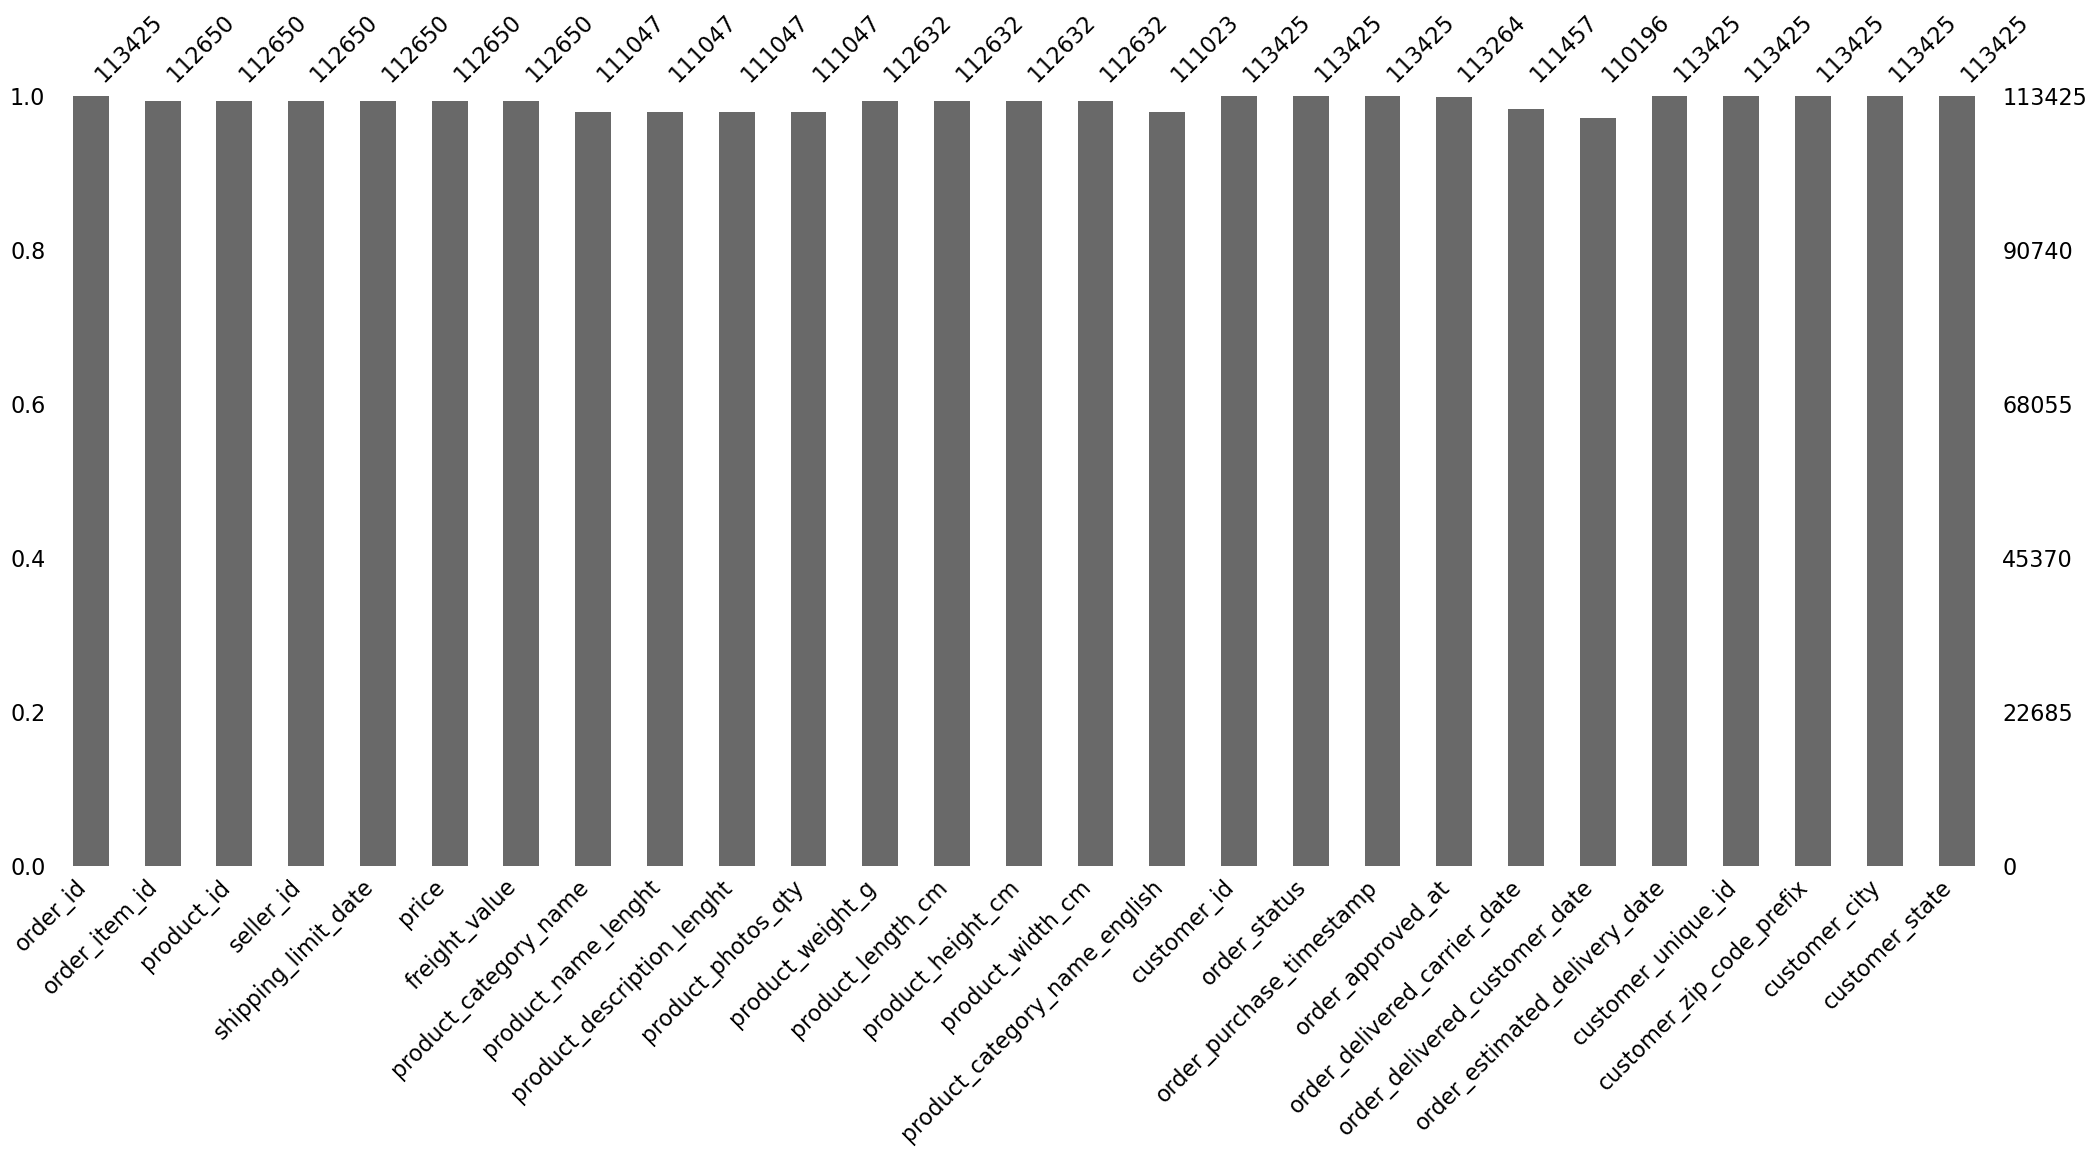

In [15]:
msno.bar(bigds)

<AxesSubplot:>

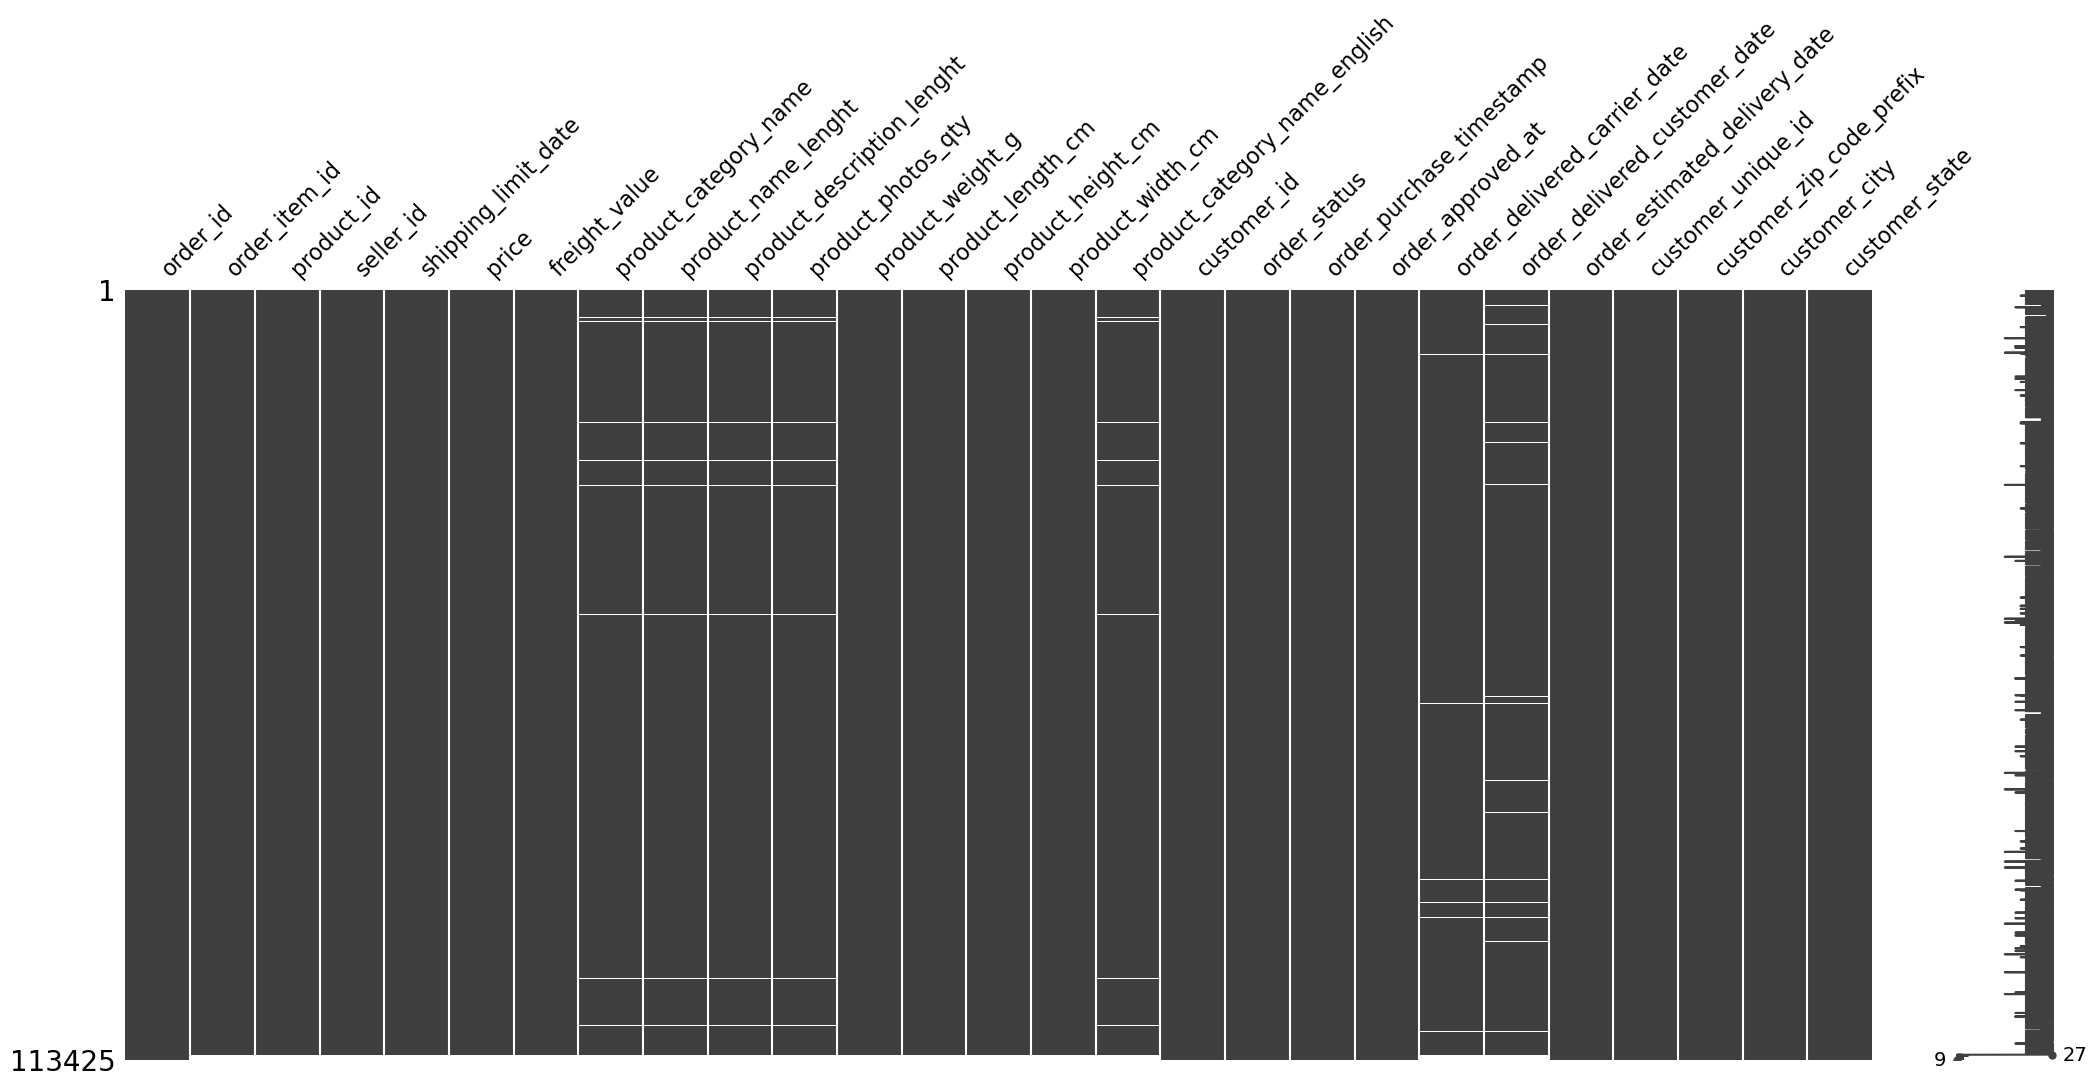

In [16]:
msno.matrix(bigds)

# as you can see there is almost no missing data, so we don't need to do much cleaning

<AxesSubplot:>

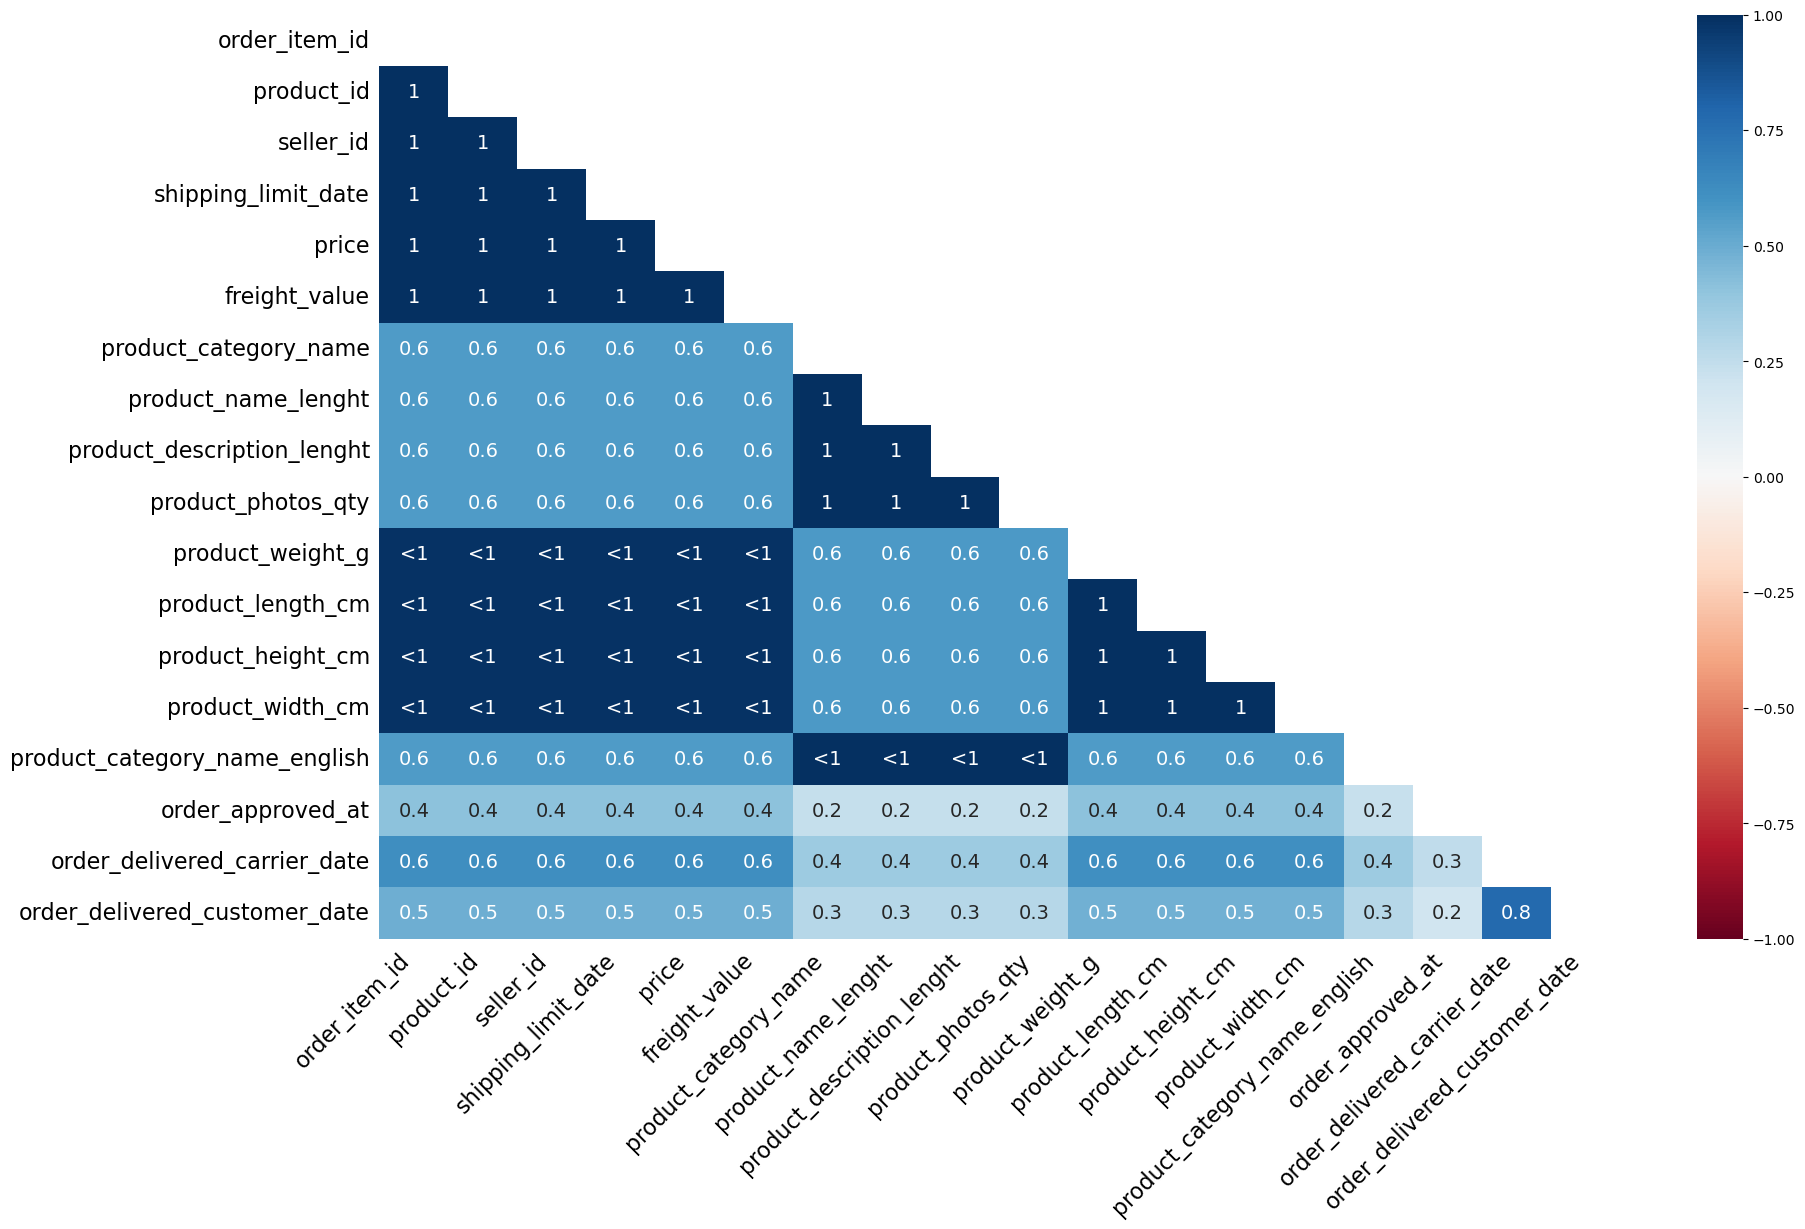

In [17]:
msno.heatmap(bigds)

## this heatmap shows how missing values are related. A score of 1 means that missing values in that column have perfect correspondence to missing values in other columns in the dataFrame. 
* For example, missing the attribute: product_weight, on an entry, has a guarantee that that same entry is also missing the product_length attribute. 

# 3. EDA

# **PRODUCT CATEGORIES**

In [18]:
ordermerge.product_category_name_english.value_counts(normalize = True).head()

bed_bath_table           0.100114
health_beauty            0.087099
sports_leisure           0.077831
furniture_decor          0.075066
computers_accessories    0.070499
Name: product_category_name_english, dtype: float64

> ## as you can see bed and bath products make up over 10% of all sales on Olist

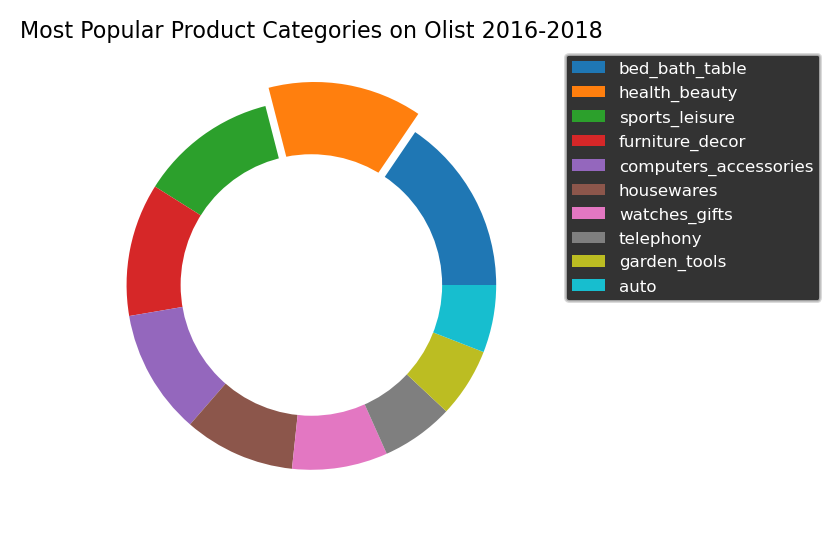

In [19]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
sns.set_style(rc = {'axes.facecolor': 'black'})
fig.patch.set_facecolor('white')
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(x = ordermerge.product_category_name_english.value_counts().head(10), 
        labels = ["","","","","","","","","",""],
        explode = explode,
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 0,
                      'antialiased': True})
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.legend(labels = ordermerge.product_category_name_english.value_counts().head(10).index.tolist(), bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize = 6,
            labelcolor = 'white')
plt.title("Most Popular Product Categories on Olist 2016-2018", color = 'black', fontsize = 8)
plt.show()

# **GEOSPATIAL**

## cities / states with the most sales on Olist

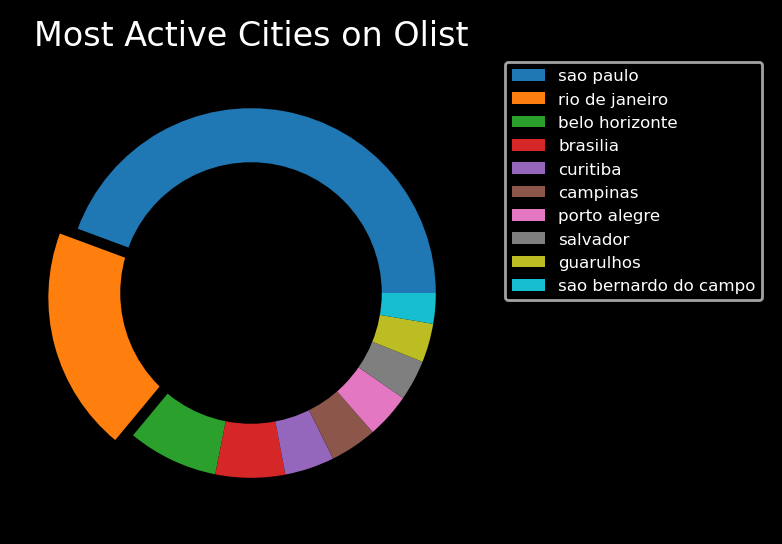

In [20]:
#popular cities
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
sns.set_style(rc = {'axes.facecolor': 'black'})
fig.patch.set_facecolor('black')
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(x = customers['customer_city'].value_counts().head(10), explode = explode, shadow = False, 
        labels = ["","","","","","","","","",""],
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 0,
                      'antialiased': True})
my_circle=plt.Circle( (0,0), 0.7, color='black')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.legend(labels = customers.customer_city.value_counts().head(10).index.tolist(), bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize = 6,
            labelcolor = 'white')
plt.title("Most Active Cities on Olist", color = 'white')
plt.show()

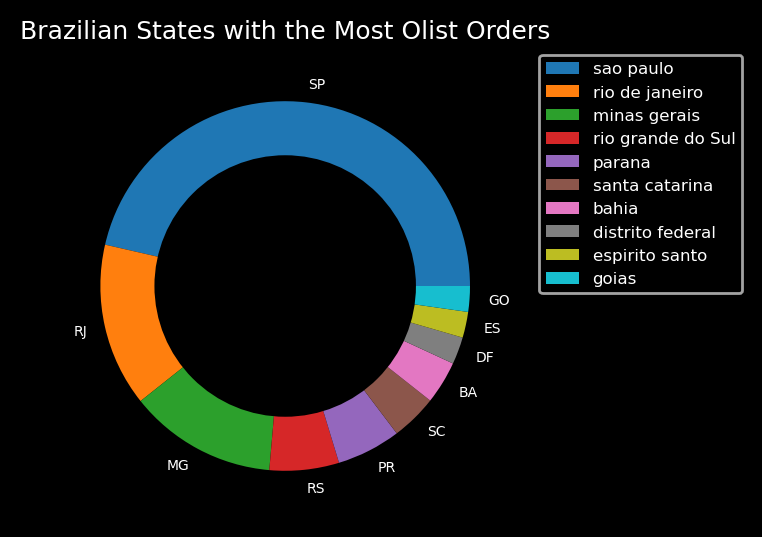

In [21]:
sns.set_style(rc = {'axes.facecolor': 'black'})
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
fig.patch.set_facecolor('black')
plt.pie(x = customers.customer_state.value_counts().head(10), 
        labels = customers.customer_state.value_counts().head(10).index.tolist(),
        textprops = {'fontsize': 5, 'color':'white'},
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 0,
                      'antialiased': True})
plt.title("Brazilian States with the Most Olist Orders", fontsize = 9, color = 'white')
my_circle=plt.Circle( (0,0), 0.7, color='black')
p=plt.gcf()
plt.legend(['sao paulo', 'rio de janeiro', 'minas gerais', 'rio grande do Sul',
            'parana', 'santa catarina', 'bahia', 'distrito federal', 'espirito santo', 'goias'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize = 6,
            labelcolor = 'white')
p.gca().add_artist(my_circle)
plt.show()

# the state of Sao Paulo makes up 41.98% of orders on Olist by itself

In [22]:
customers.customer_state.value_counts(normalize = True).head(5)

SP    0.419807
RJ    0.129242
MG    0.117004
RS    0.054967
PR    0.050734
Name: customer_state, dtype: float64

# **PRICE**

<AxesSubplot:title={'center':'Order Cost Distribution - Price per Order'}, xlabel='Price Euros', ylabel='count'>

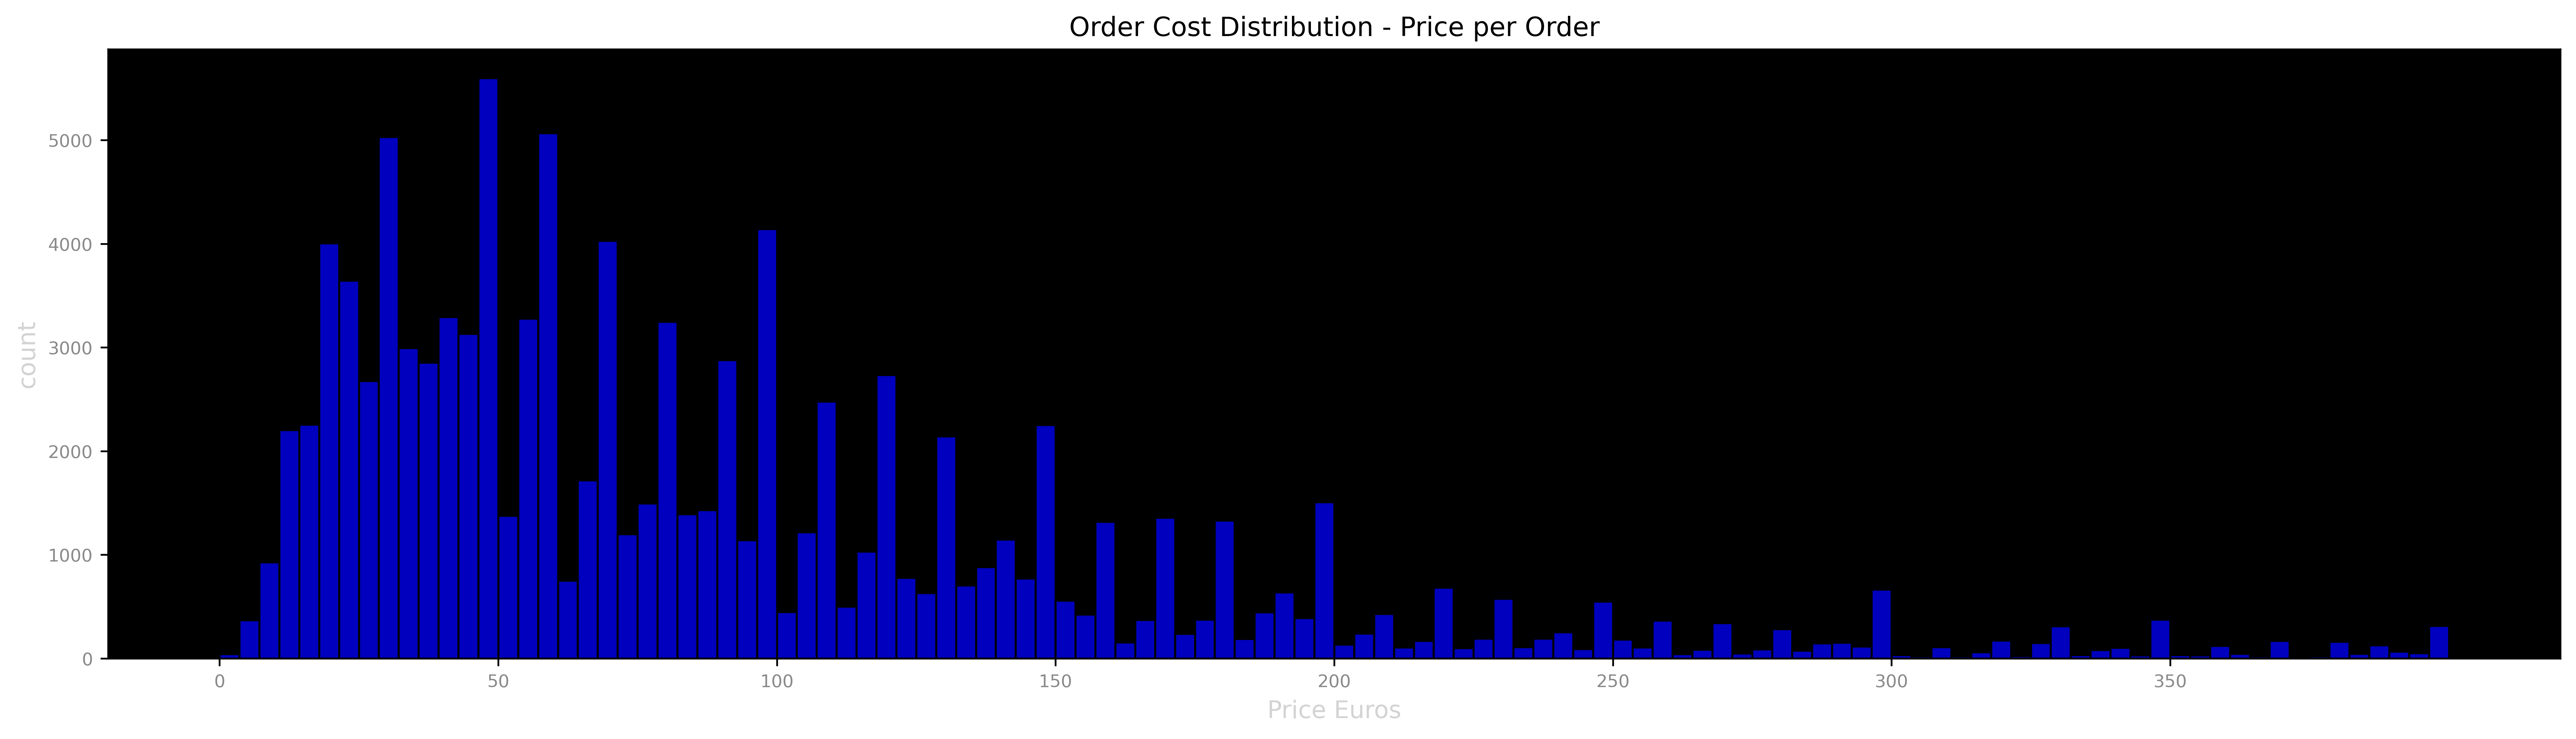

In [23]:
#price_per_order distr
fig, ax = plt.subplots(figsize=(20, 5), dpi=500)
sns.set_style(rc = {'axes.facecolor': 'black'})
plt.title("Order Cost Distribution - Price per Order")
plt.xlabel('Price Euros', fontsize = '11', color = 'lightgrey')
plt.ylabel('count', fontsize = '11', color = 'lightgrey')
plt.xticks(np.arange(0, 400, step=50), fontsize = 8, color = '#8a8a8a')  # Set label locations.
plt.yticks(fontsize = 8, color = '#8a8a8a')
plt.grid(linestyle=' ', alpha=0.7)
sns.histplot(order_items.price, binrange = (0,400), color = 'blue')

# the average price of an order on Olist is 120.65 euros

In [24]:
print("The average price of an Olist order is " + str(round(order_items.price.mean(),2)))

The average price of an Olist order is 120.65


# **ORDER VOLUME DISTRIBUTION**

# here are the 10 most popular days on Olist from 2017-2018

In [25]:
#orders by day
orders['order_day'] = orders.order_purchase_timestamp.apply(lambda x: x.split(" ")[0])
orders_per_day = pd.DataFrame(orders.order_day.value_counts())
#ten most popular days for orders
orders_per_day.head(10)

,order_day
2017-11-24,1176
2017-11-25,499
2017-11-27,403
2017-11-26,391
2017-11-28,380
2018-08-06,372
2018-05-07,372
2018-08-07,370
2018-05-14,364
2018-05-16,357


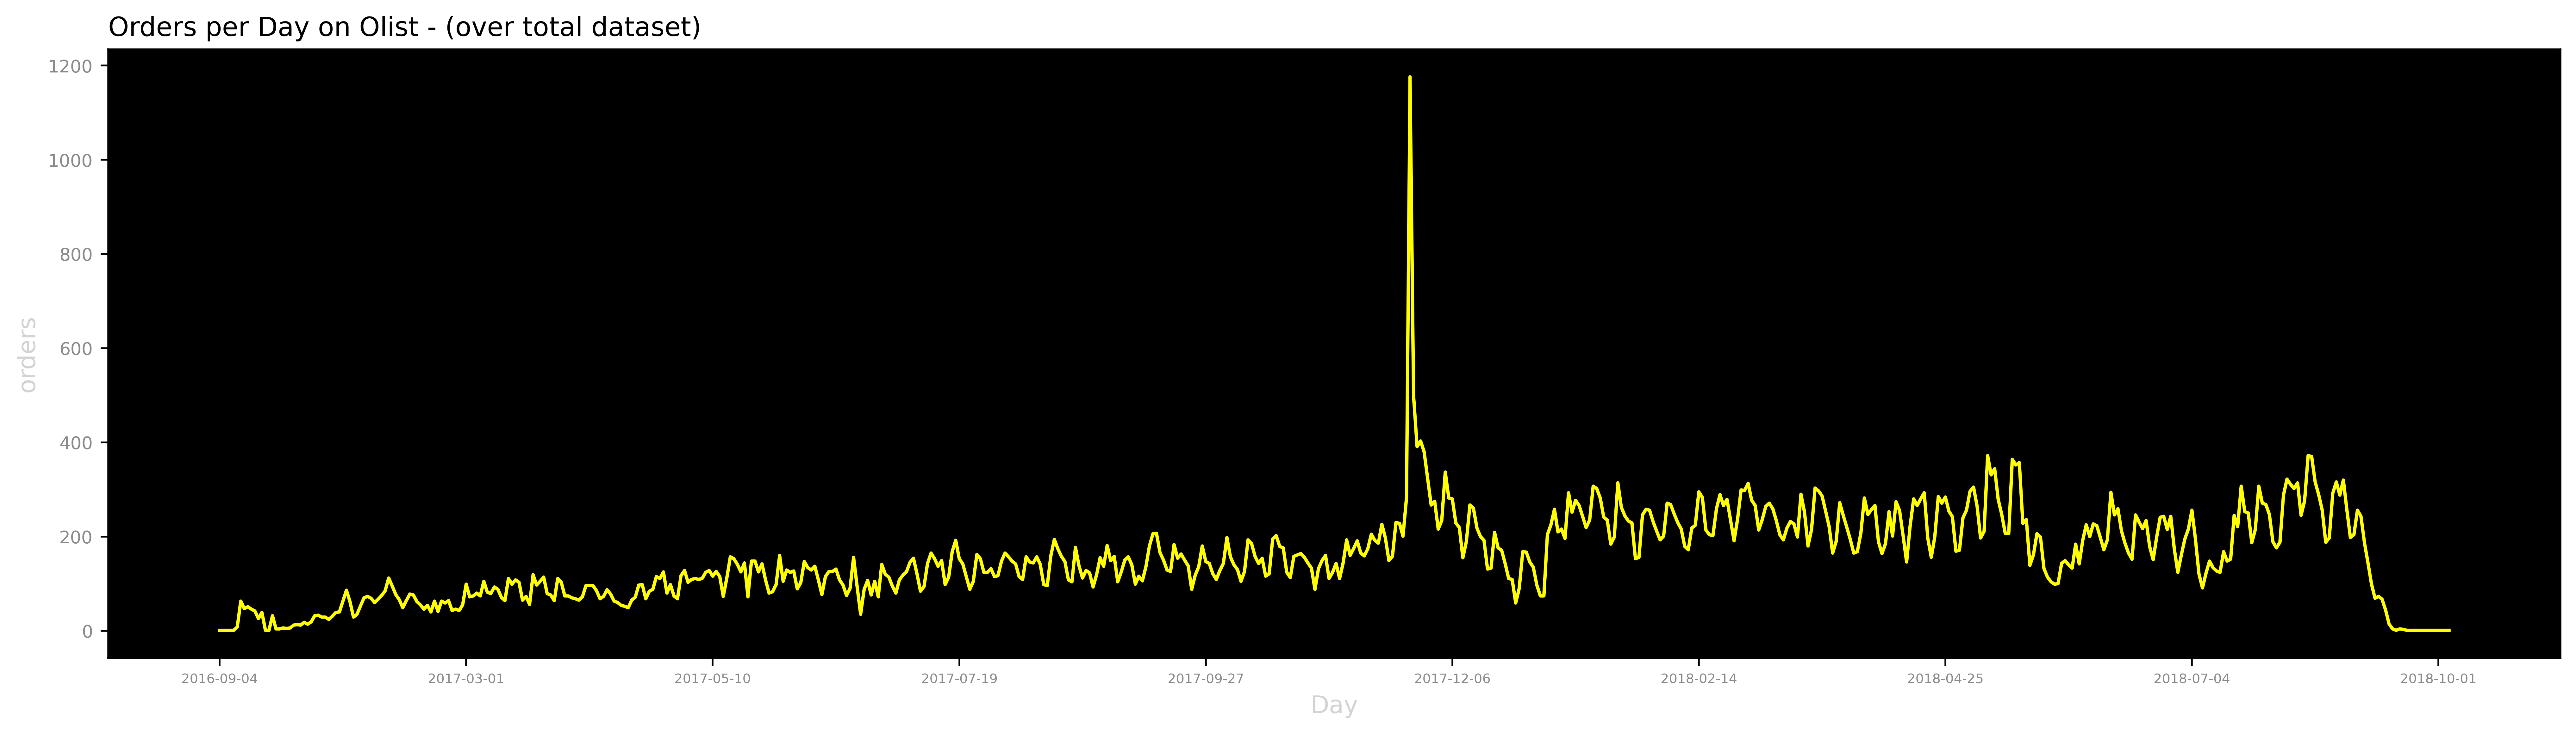

In [26]:
orders_per_day = orders_per_day.sort_index()
sns.set_style(rc = {'axes.facecolor': 'black'})
fig, ax = plt.subplots(figsize=(20, 5), dpi=500)
sns.lineplot(x = orders_per_day.index, y = orders_per_day.order_day, color = 'yellow')
plt.xticks([])
csfont = {'fontname':'swag'}
plt.xlabel('Day', fontsize = '11', color = 'lightgrey')
plt.ylabel('orders', fontsize = '11', color = 'lightgrey')
#locs, labels = xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 650, step=70), fontsize = 6, color = '#8a8a8a')  # Set label locations.
plt.yticks(fontsize = 8, color = '#8a8a8a')
#plt.xticks(np.arange(3), ['Tom', 'Dick', 'Sue'])  # Set text labels.
plt.title("Orders per Day on Olist - (over total dataset)",**csfont, loc = 'left')
plt.grid(linestyle=' ', alpha=0.7)
plt.show()

In [27]:
#two lines of the yearly purchases for comparison
test = orders_per_day.reset_index()
test2 = test[test['index'] >= "2017-09-05"]
test2 = test2[test2['index'] <= "2018-09-05"]
test3 = test[test['index'] < "2017-09-05"]
test2['index'] = pd.to_datetime(test2['index'], format='%Y-%m-%d')
test3['index'] = pd.to_datetime(test3['index'], format='%Y-%m-%d')
test2['index'] = test2['index'].dt.strftime('%m-%d')
test3['index'] = test3['index'].dt.strftime('%m-%d')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


## here you can see how Olist has incresed in popularity from 2017 to 2018.

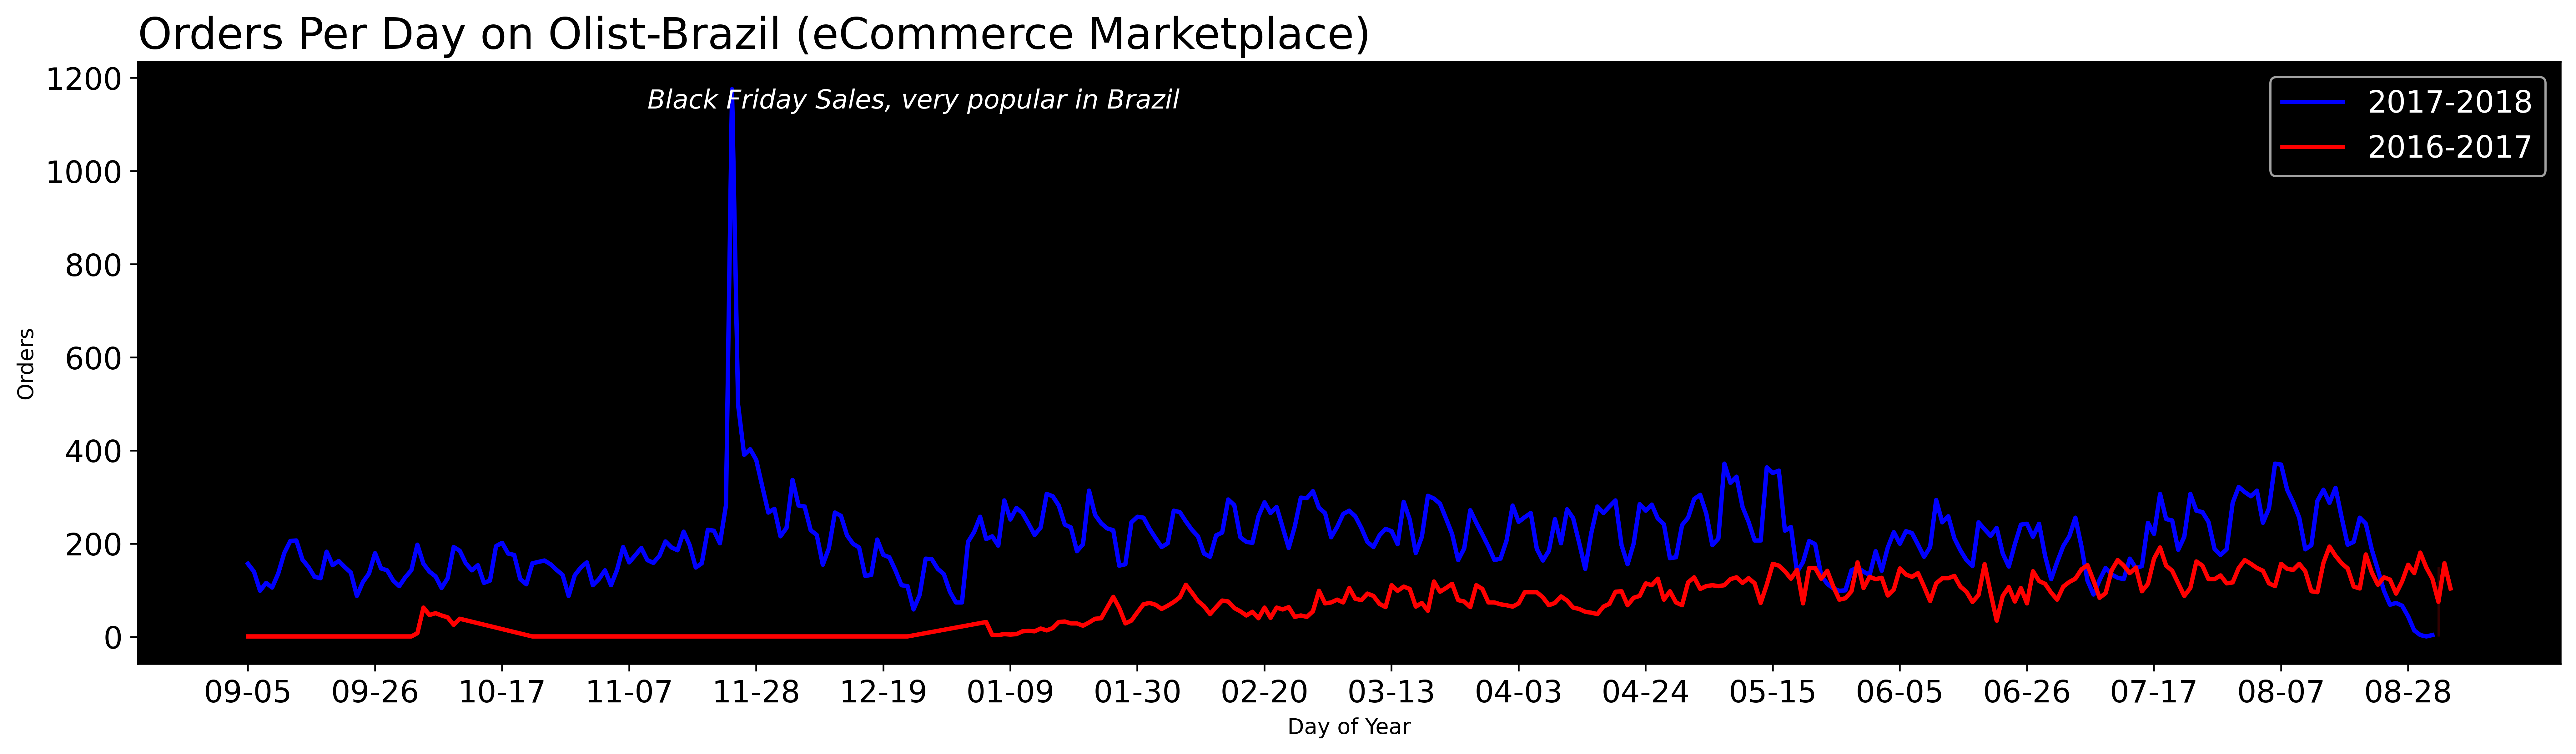

In [28]:
sns.set_style(rc = {'axes.facecolor': 'black'})
fig, ax = plt.subplots(figsize=(20, 5), dpi=500)
sns.lineplot(x = test2['index'], y = test2.order_day, label='2017-2018', color = 'blue', linewidth = 2)
sns.lineplot(x = test3['index'], y = test3.order_day, label='2016-2017', color = 'red', linewidth = 2)
plt.xticks([])
plt.xticks(np.arange(0, 358, step=21)) 
plt.xlabel('Day of Year')
plt.ylabel('Orders')
plt.title("Orders Per Day on Olist-Brazil (eCommerce Marketplace)", fontsize = 20, loc = 'left')
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14, labelcolor = 'white')
plt.text(110, 1150, "Black Friday Sales, very popular in Brazil", 
       fontsize = 12,          # Size
       fontstyle = "oblique",  # Style
       color = "white",          # Color
       ha = "center", # Horizontal alignment
       va = "center") 
plt.grid(linestyle=' ', alpha=0.7)
plt.show()

### Black Friday is very popular in Brazil despite being an American holiday. As you can see sales skyrocketed during Black Friday Weekend. 

# **SHIPPING**

In [29]:
#information about orders
#     time it takes to approve, time it takes to ship, etc

duration = orders[['order_purchase_timestamp', 'order_delivered_customer_date']]
duration['order_purchase_timestamp'] = pd.to_datetime(duration['order_purchase_timestamp'])
duration['order_delivered_customer_date'] = pd.to_datetime(duration['order_delivered_customer_date'])
test = duration.order_purchase_timestamp - duration.order_delivered_customer_date
test = test.apply(lambda x: -1* (x.days))
print('This is the average duration it takes to receive an order ' + str(test.mean()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


This is the average duration it takes to receive an order 13.094075210415026


# The average duration it takes to receive an order off of Olist is ~ 13 days. 

In [30]:
#successful delivery percentages
orders['order_status'].value_counts(normalize = True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

> ### 97% successful delivery rate

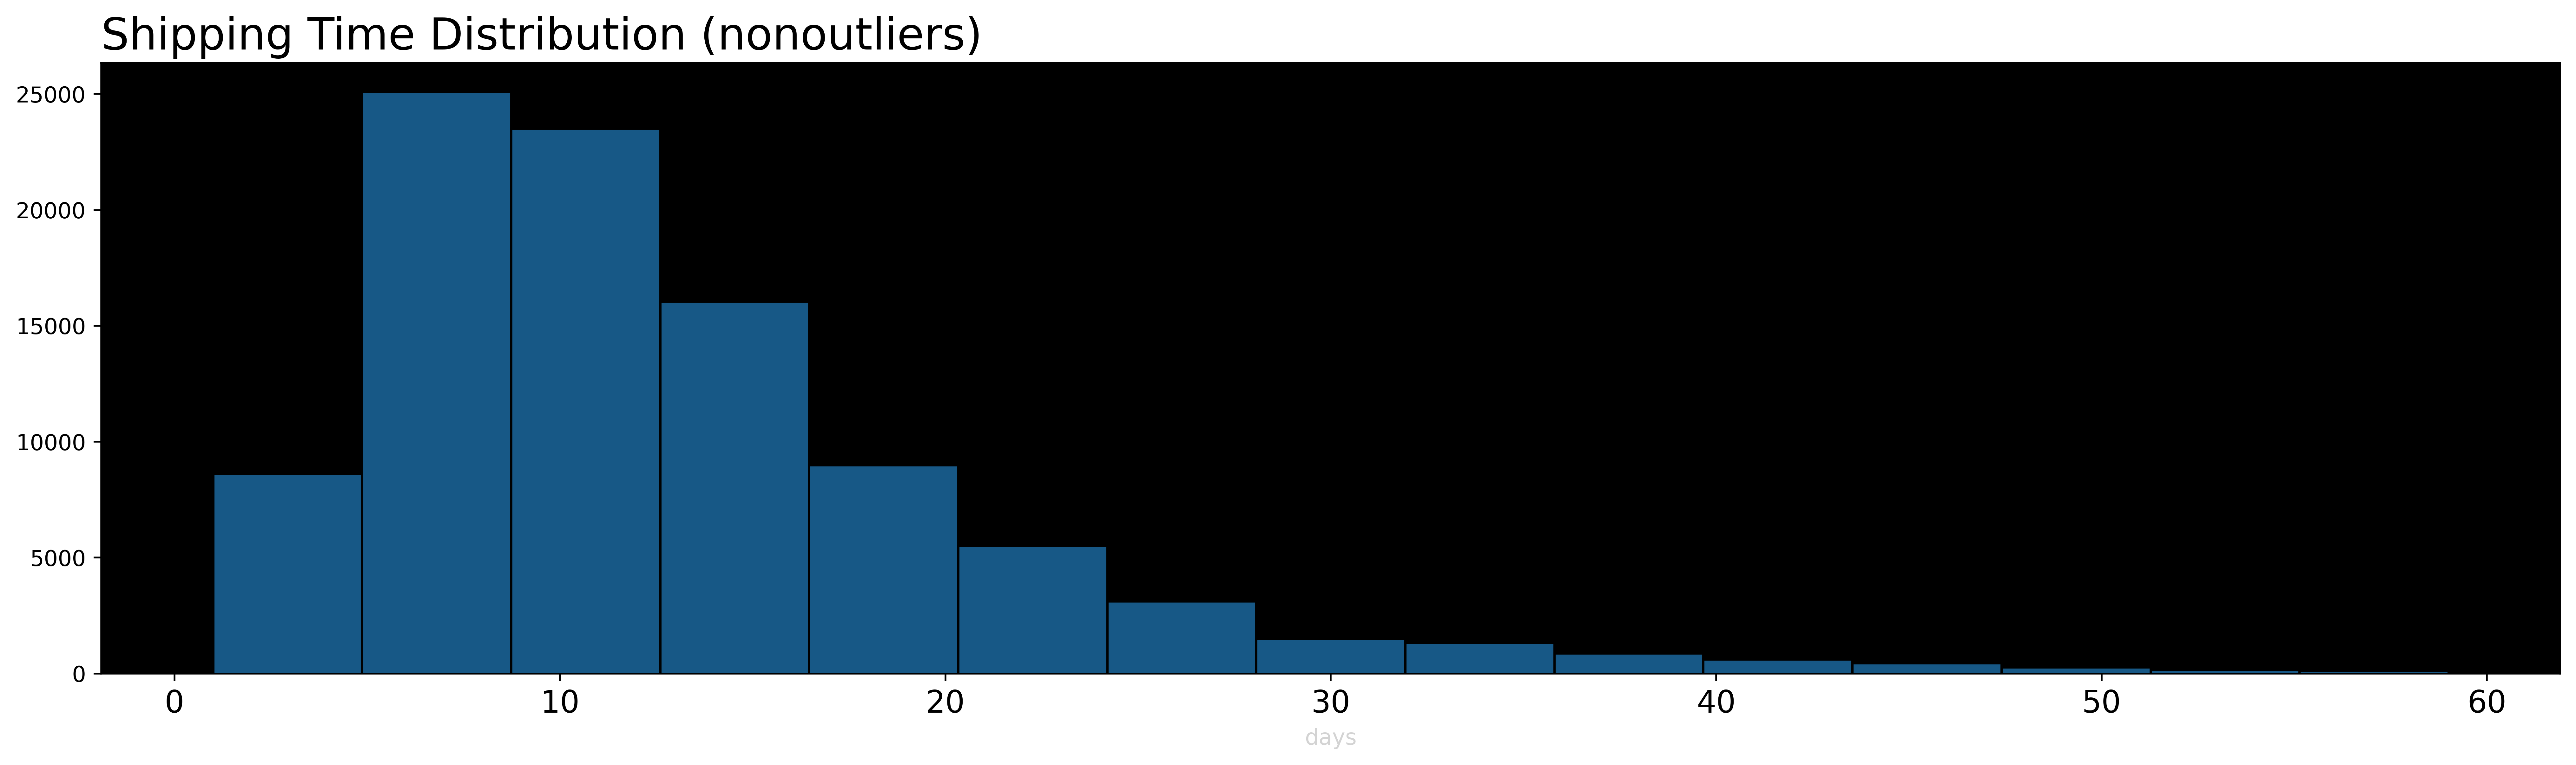

In [31]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=500)
test2 = test[test > 60]
test = test[test < 60]
sns.histplot(test, bins = 15)
plt.title('Shipping Time Distribution (nonoutliers)', fontsize = 20, loc = 'left')
plt.xticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('days', color = 'lightgrey')
plt.show()

### however, some packages can take from two months to two hundred days!

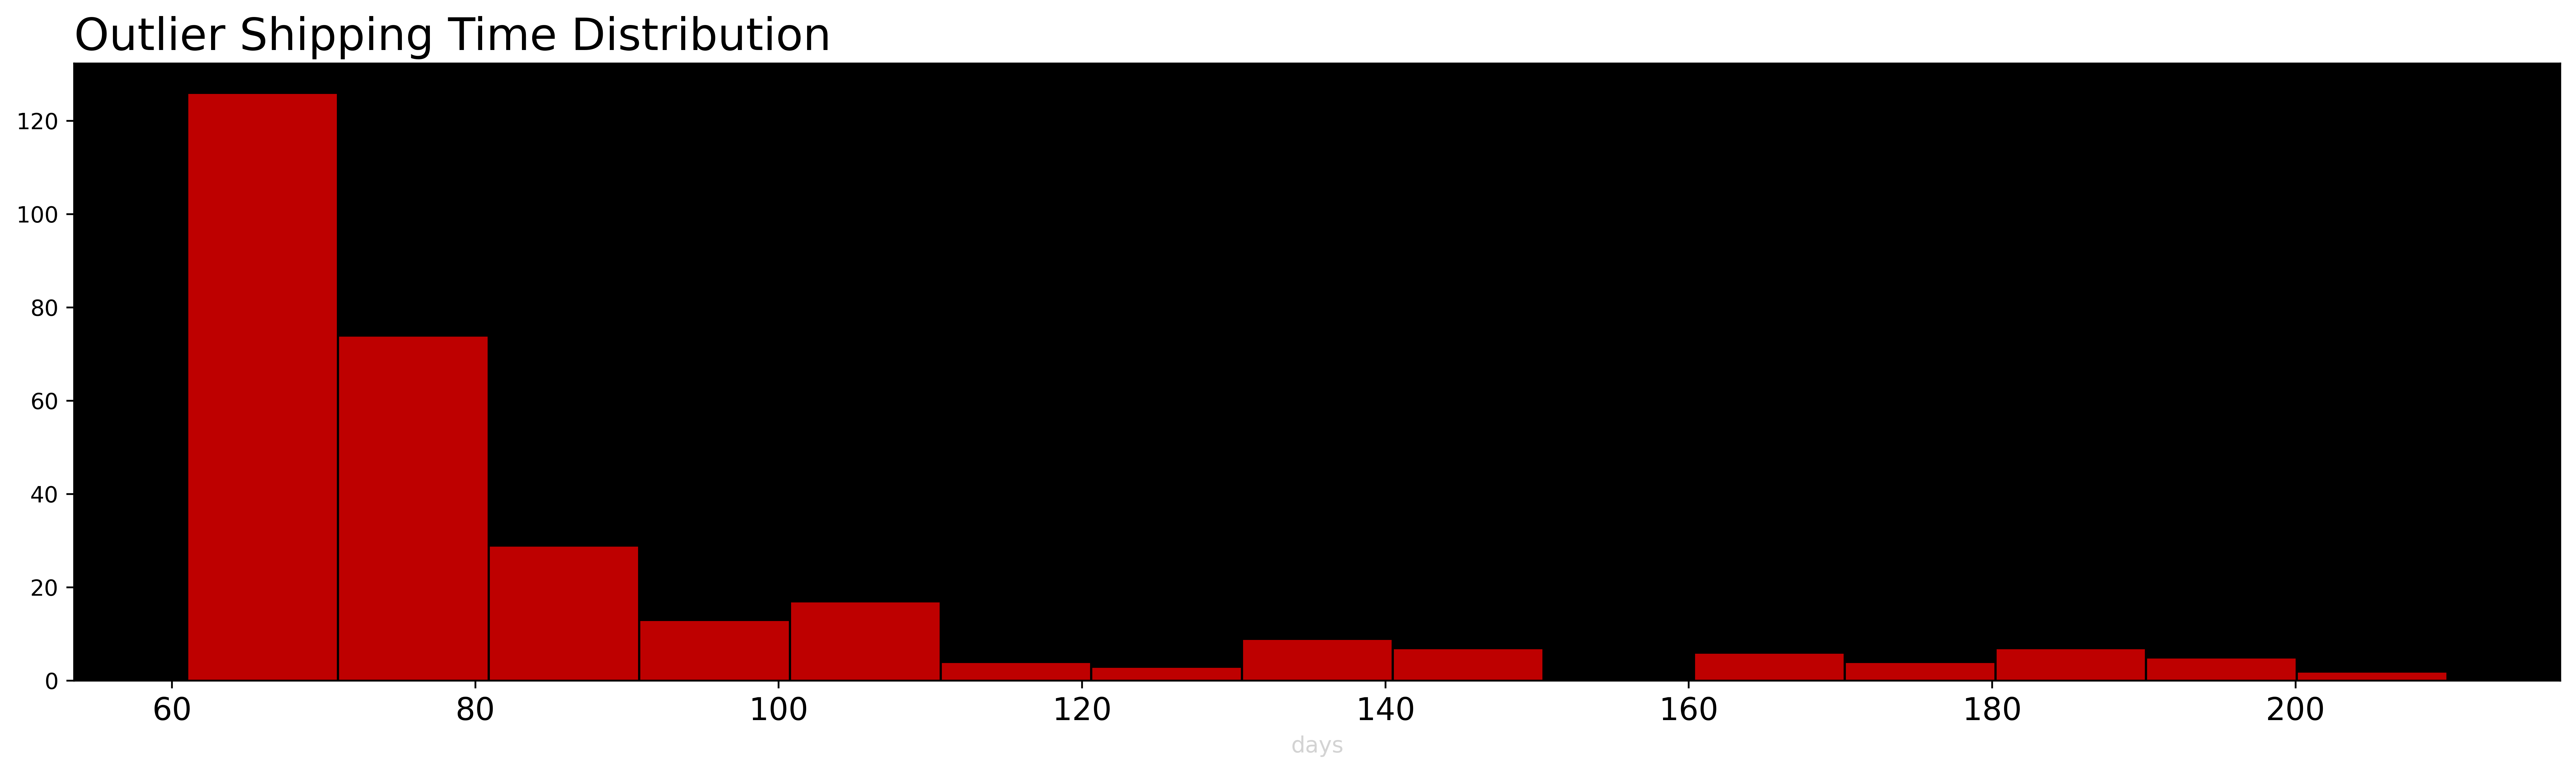

In [32]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=500)
sns.histplot(test2, bins = 15, color = 'red')
plt.title('Outlier Shipping Time Distribution', fontsize =20, loc = 'left')
plt.xticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('days', color = 'lightgrey')
plt.show()

# **REVIEWS**

<AxesSubplot:title={'left':'Olist Overall Review Scores'}, xlabel='Score', ylabel='count'>

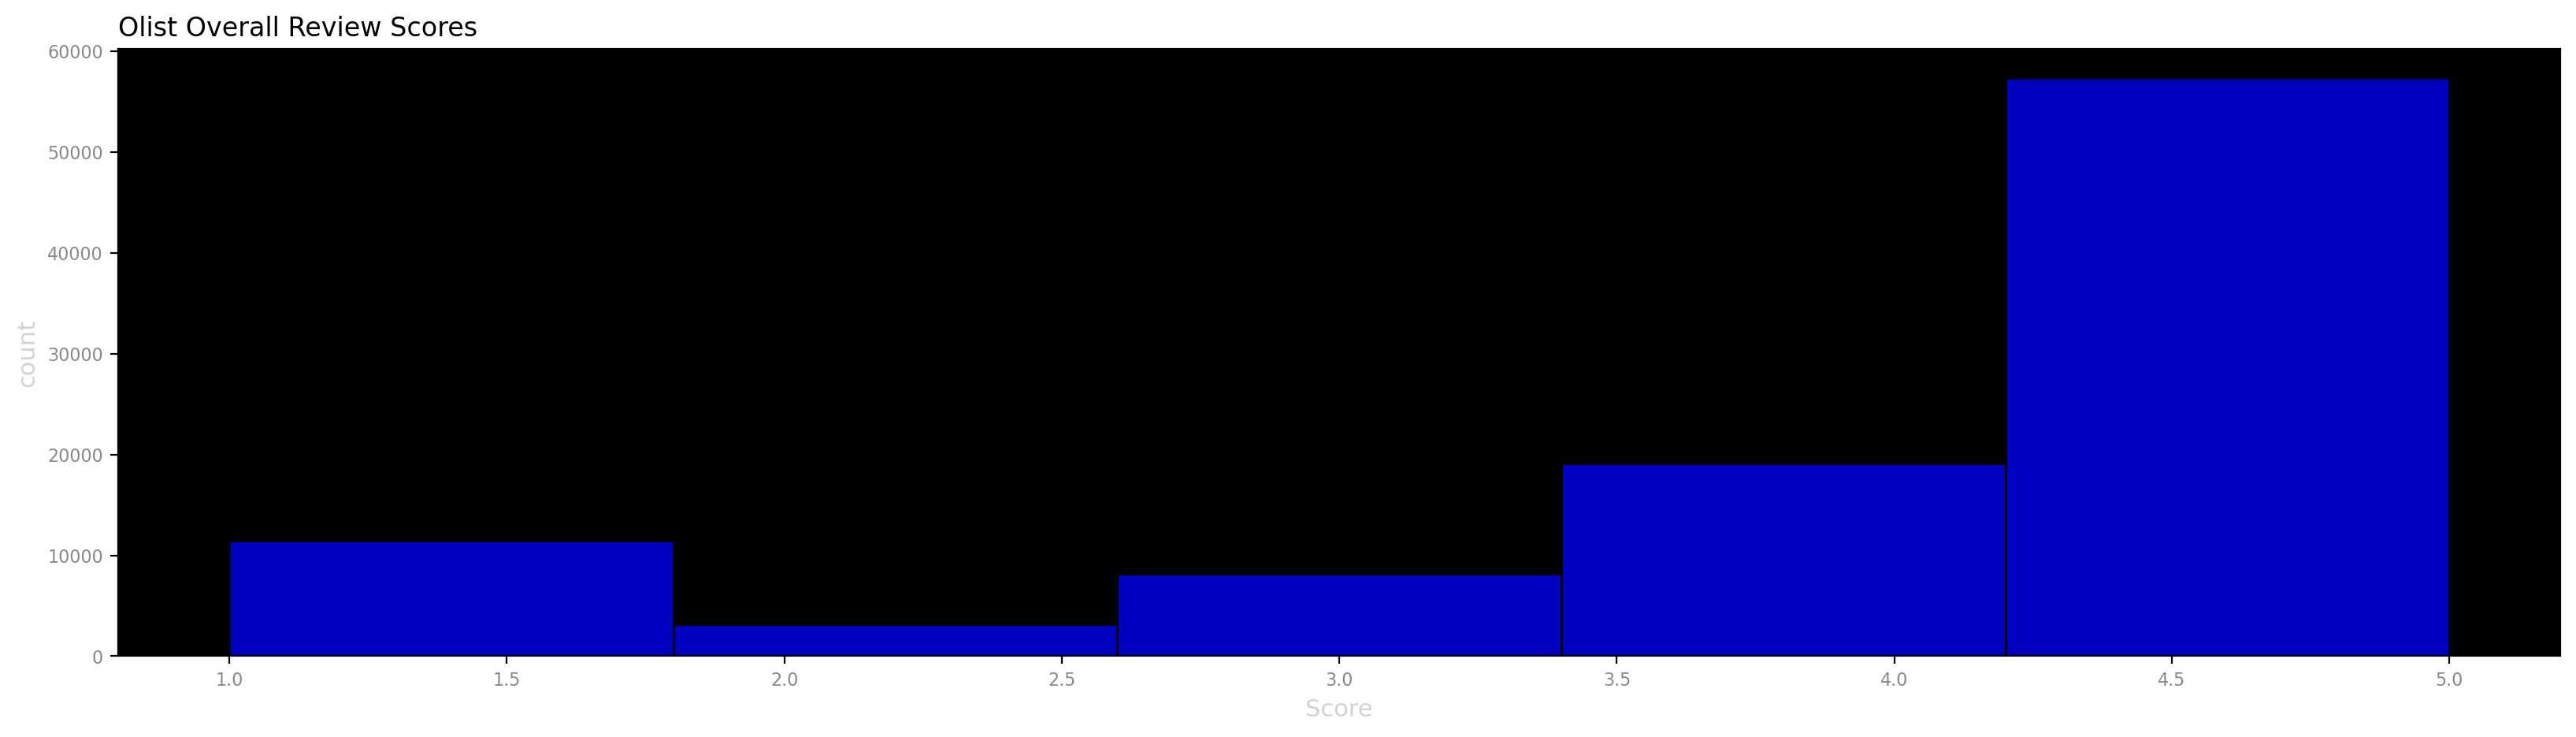

In [33]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=200)
sns.set_style(rc = {'axes.facecolor': 'black'})
plt.title("Olist Overall Review Scores", loc = 'left')
plt.xlabel('Score', fontsize = '11', color = 'lightgrey')
plt.ylabel('count', fontsize = '11', color = 'lightgrey')
plt.xticks(fontsize = 8, color = '#8a8a8a')  # Set label locations.
plt.yticks(fontsize = 8, color = '#8a8a8a')
plt.grid(linestyle=' ', alpha=0.7)
sns.histplot(reviews['review_score'], color = 'blue', bins = 5)

# The average review score for products on Olist is ~ 4/5. 
## however, certain product groups regularly receive higher ratings

In [34]:
hold = pd.DataFrame(reviewmerge[['product_category_name_english', 'review_score']])
hold['out'] = 5
hold['review_score'].sum()/ (len(hold['review_score']) * 5) * 5

4.032472502046773

In [35]:
store = hold.groupby('product_category_name_english').sum()
connect = store['review_score'] / store['out']
connect = connect * 5 
connect.sort_values(ascending = False).head(5)

product_category_name_english
cds_dvds_musicals            4.642857
fashion_childrens_clothes    4.500000
books_general_interest       4.446266
costruction_tools_tools      4.444444
flowers                      4.419355
dtype: float64

## and some regularly receive poor ratings

In [36]:
connect.sort_values(ascending = True).head(5)

product_category_name_english
security_and_services    2.500000
diapers_and_hygiene      3.256410
office_furniture         3.493183
home_comfort_2           3.629630
fashion_male_clothing    3.641221
dtype: float64

# basic sentiment analysis using Vader

In [37]:
z = reviews.iloc[5]['review_comment_message']
dfrev = pd.DataFrame([['example', {'neg' : 0.0, 'neu' : 1.0, 'pos': 0.0}] , ['example', {'neg' : 0.0, 'neu' : 1.0, 'pos': 0.0}]]
                     , columns = ['review', 'polarity-scores'])
testarr = []
# Vader Sentiment Intensity Analyzer 
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is really shitty!")

reviews['polarity_scores'] = reviews['review_comment_message'].apply(lambda x: sia.polarity_scores(str(x)))
testdb = reviews[['review_score', 'review_comment_message', 'polarity_scores']]
testdb['compound'] = testdb['polarity_scores'].apply(lambda score_dict: score_dict['compound'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## top 10 best reviews according to SIA

In [38]:
y = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = False).head(10)[['review_comment_message', 'compound']])
y.head(10)

,review_comment_message,compound
63315,"Produtos lindos super da hora, chegaram em men...",0.9136
96735,Adoreiii os capachos! super lindos <3 A entreg...,0.8748
58406,"Além do produto ser excelente, fui mt bm atend...",0.8741
91235,Ótimo produto!! Chegou super rápido!!! Ótima q...,0.8741
6607,"O produto é excelente, muito resistente e aten...",0.8741
96774,"Super satisfeita com o produto, o atendimento ...",0.8741
90824,Foi uma compra super tranquila. Super recomend...,0.8741
12279,"Entrega super rápida, a mercadoria chegou muit...",0.8741
35768,"Adorei!!!! Super bem acabada, versátil, pequen...",0.8741
39522,"Entrega super rápida, veio bem antes do prazo ...",0.8650


In [39]:
#           Best Review 
y.loc[63315]['review_comment_message']

'Produtos lindos super da hora, chegaram em menos de 5 dias da data da compra e a previsão eram quase 30 dias , qualidade super boa , super indico '

> ### 'Super beautiful products, they arrived in less than 5 days from the date of purchase and the forecast was almost 30 days, super good quality, I highly recommend'

## top 10 worst reviews according to SIA

In [40]:
x = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = True).head(10)[['review_comment_message', 'compound']])
x.head(10)

,review_comment_message,compound
98629,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039
60968,MAS ACHO QUE TALVEZ NÃO FOI ENTRGUE NO PRAZO!!...,-0.8740
16434,Comprei 3 delas e chegaram no prazo. Ocorre qu...,-0.8402
1904,No site da lannister a data de entrega seria 0...,-0.8402
58277,O produto veio com defeito e esse site criou m...,-0.8317
44831,"FIZ UMA COMPRA DE DUAS LUMINÁRIAS , MEIA LUA ,...",-0.8316
76003,enviaram um email falando que não tinham no e...,-0.7783
72658,Produto estava no site c/ o prazo de 8 dias út...,-0.7783
25955,"Fiz uma compra de dois produtos, um relógio no...",-0.7783
46016,Apesar da paralisação dos caminhoneiros no fin...,-0.7783


In [41]:
x.loc[98629]['review_comment_message']

'Comprei 3 Whey Protein e 1 Hemo Rage no mesmo pedido, e o Hemo Rage não veio! No entanto até o momento não recebi nenhuma informação do vendedor, apenas apareceu pra mim como se tivesse tudo entregue!'

> ### "I bought 3 Whey Protein and 1 Hemo Rage in the same order, and the Hemo Rage didn't come! However, so far I have not received any information from the seller, it just appeared to me as if everything had been delivered!'

## most popular words in NEGATIVE reviews

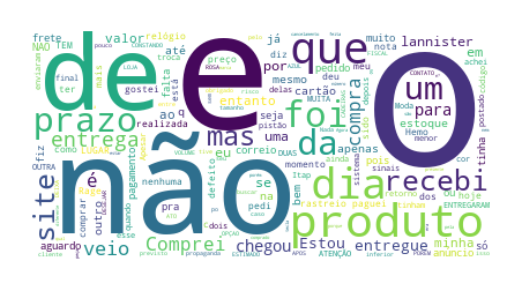

In [42]:
fig, ax = plt.subplots(figsize=(3,1), dpi=300)
reviews2 = reviews[reviews.review_score < 2]
reviews3 = reviews2[reviews2.review_score > 4]
bad_reviews = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = True).head(50)[['review_comment_message', 'compound']])
text = " ".join(review for review in bad_reviews.review_comment_message)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## most popular words in POSITIVE reviews

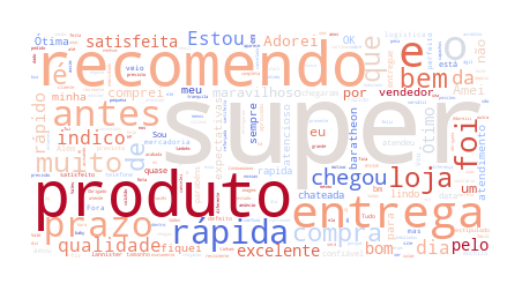

In [43]:
fig, ax = plt.subplots(figsize=(3,1), dpi=300)
reviews4 = reviews2[reviews2.review_score <= 2]
good_reviews = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = False).head(50)[['review_comment_message', 'compound']])
text = " ".join(review for review in good_reviews.review_comment_message)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white', colormap = 'coolwarm').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 4. involving the marketing dataset

In [44]:
#marketing datasets
cd = pd.read_csv('/kaggle/input/marketing-funnel-olist/olist_closed_deals_dataset.csv')
mql = pd.read_csv('/kaggle/input/marketing-funnel-olist/olist_marketing_qualified_leads_dataset.csv')

In [45]:
mql['first_contact_date'] = pd.to_datetime(mql['first_contact_date'])
mql['first_contact_date'] = mql['first_contact_date'].dt.to_period('M')
df = pd.DataFrame(mql['first_contact_date'].value_counts()).sort_index()

# Marketing Channels First-Contact Volume over Time

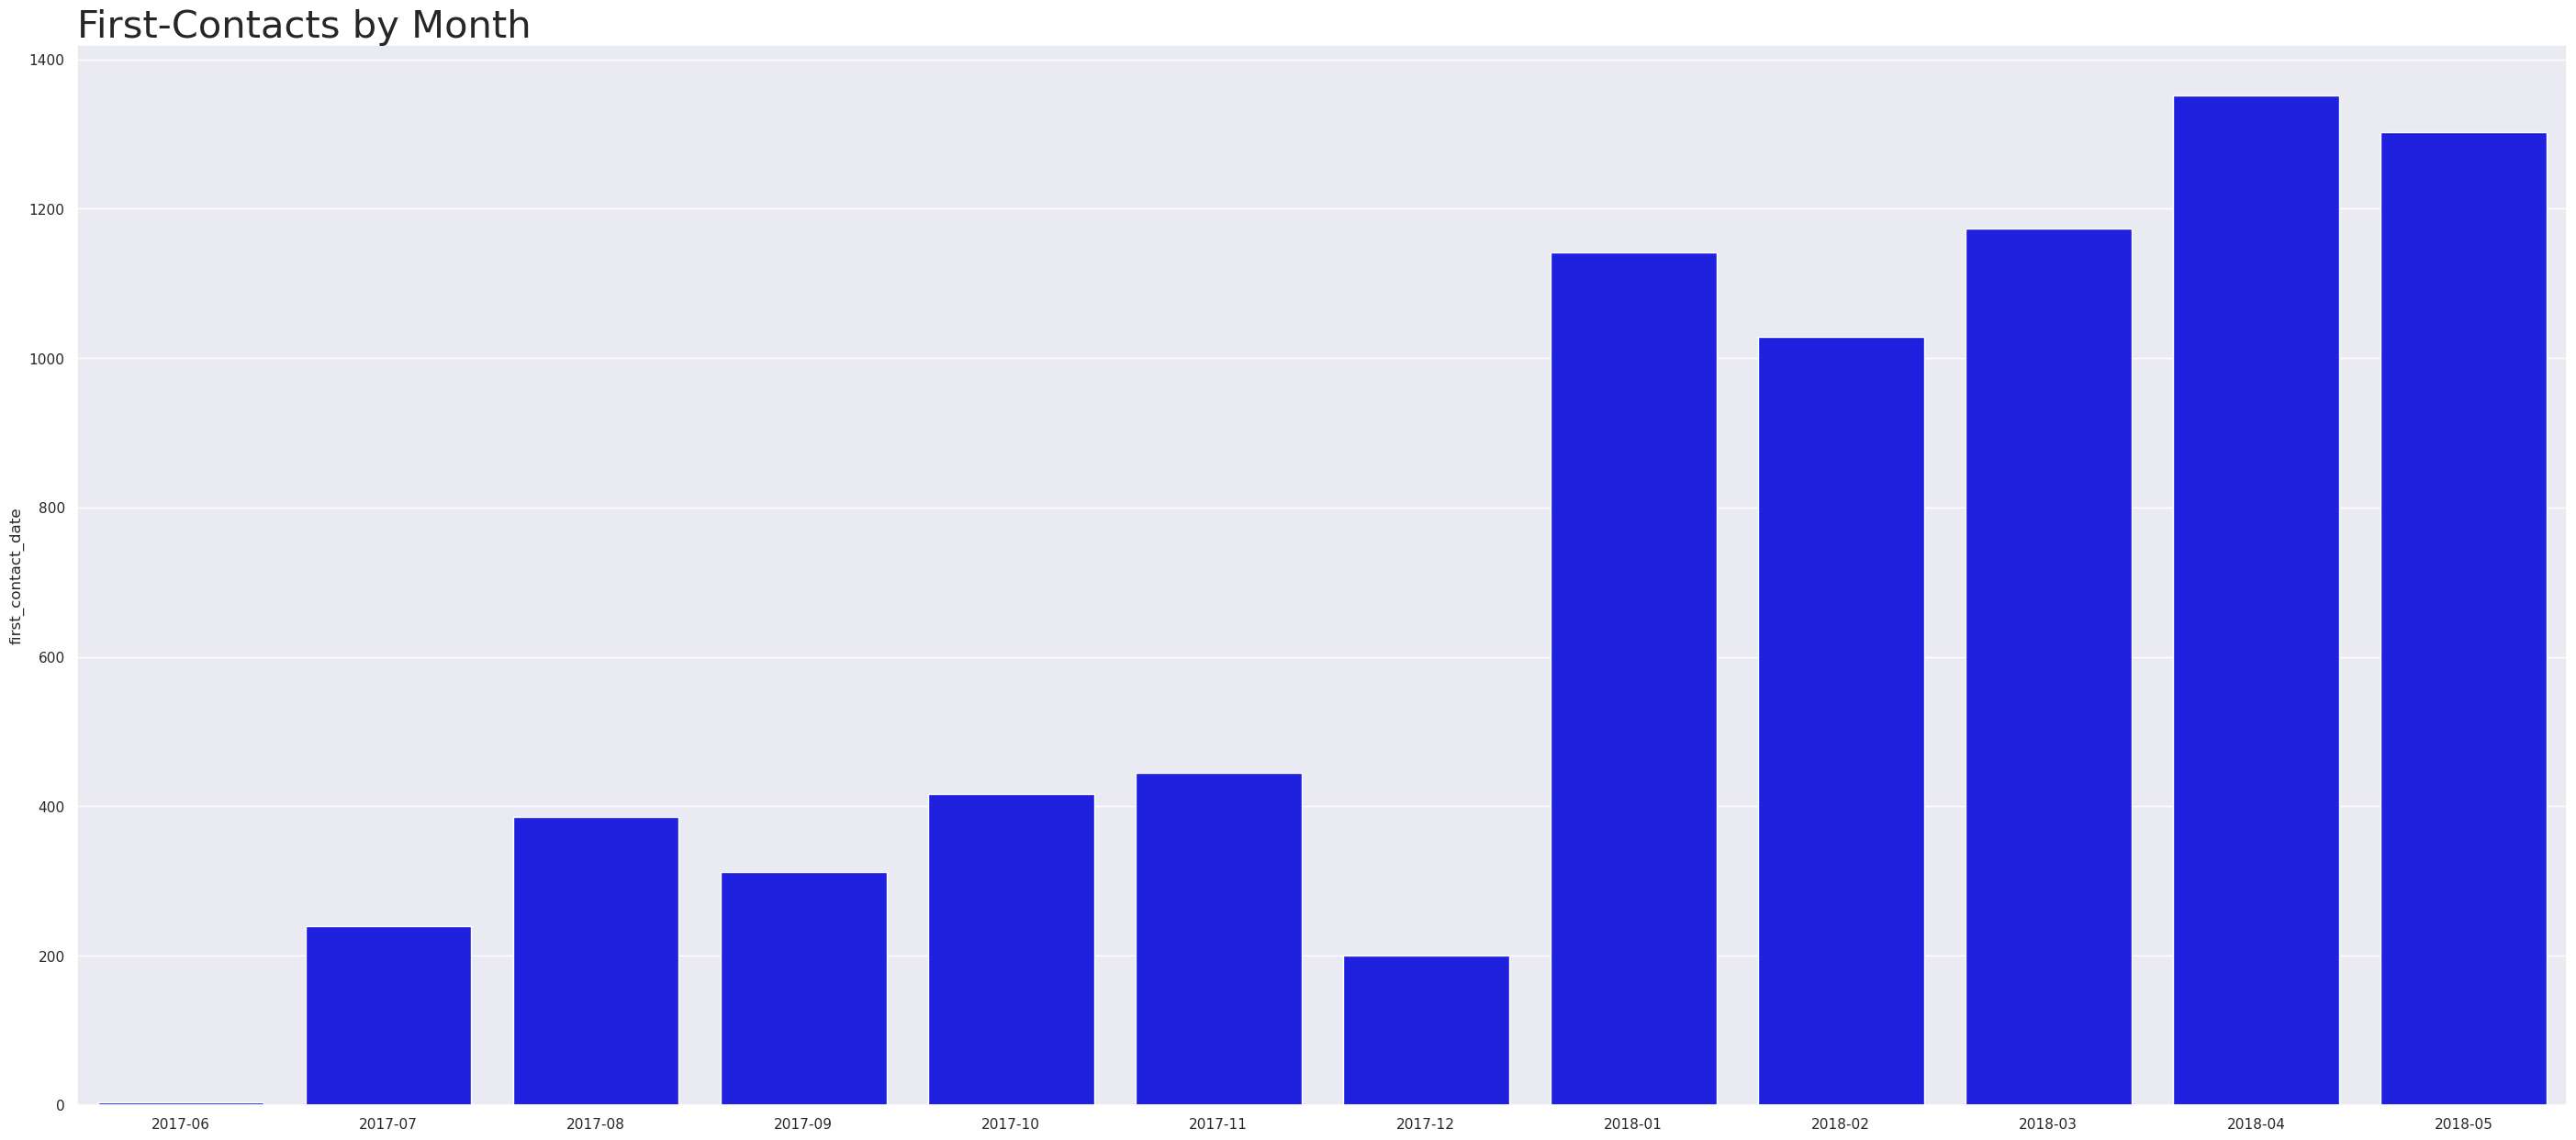

In [46]:
df = pd.DataFrame(mql['first_contact_date'].value_counts()).sort_index()
sns.set(rc={'figure.figsize':(35, 15)})
plt.title("First-Contacts by Month", loc = 'left', fontsize = 30)
sns.barplot(x = df.index, y = df.first_contact_date, color = 'blue')
plt.show()

In [47]:
leads = mql.merge(cd, on = 'mql_id', how = 'left')

In [48]:
rel_conversion_rate = len(cd)/len(leads)
print("This is the relative global conversion rate across all marketing channels " + str(rel_conversion_rate))

This is the relative global conversion rate across all marketing channels 0.10525


## the global conversion rate is 10.525% accross all channels, ie, 10.5% of all original leads closed deals with Olist

In [49]:
store = pd.DataFrame(leads.groupby('origin').apply(lambda x: len(x[x.won_date.isna() == False]) / len(x))).reset_index()
conv = store.iloc[:,1]
store['conversion_rate'] = conv
store = store[['origin', 'conversion_rate']]

## histplot of marketing channel distributions

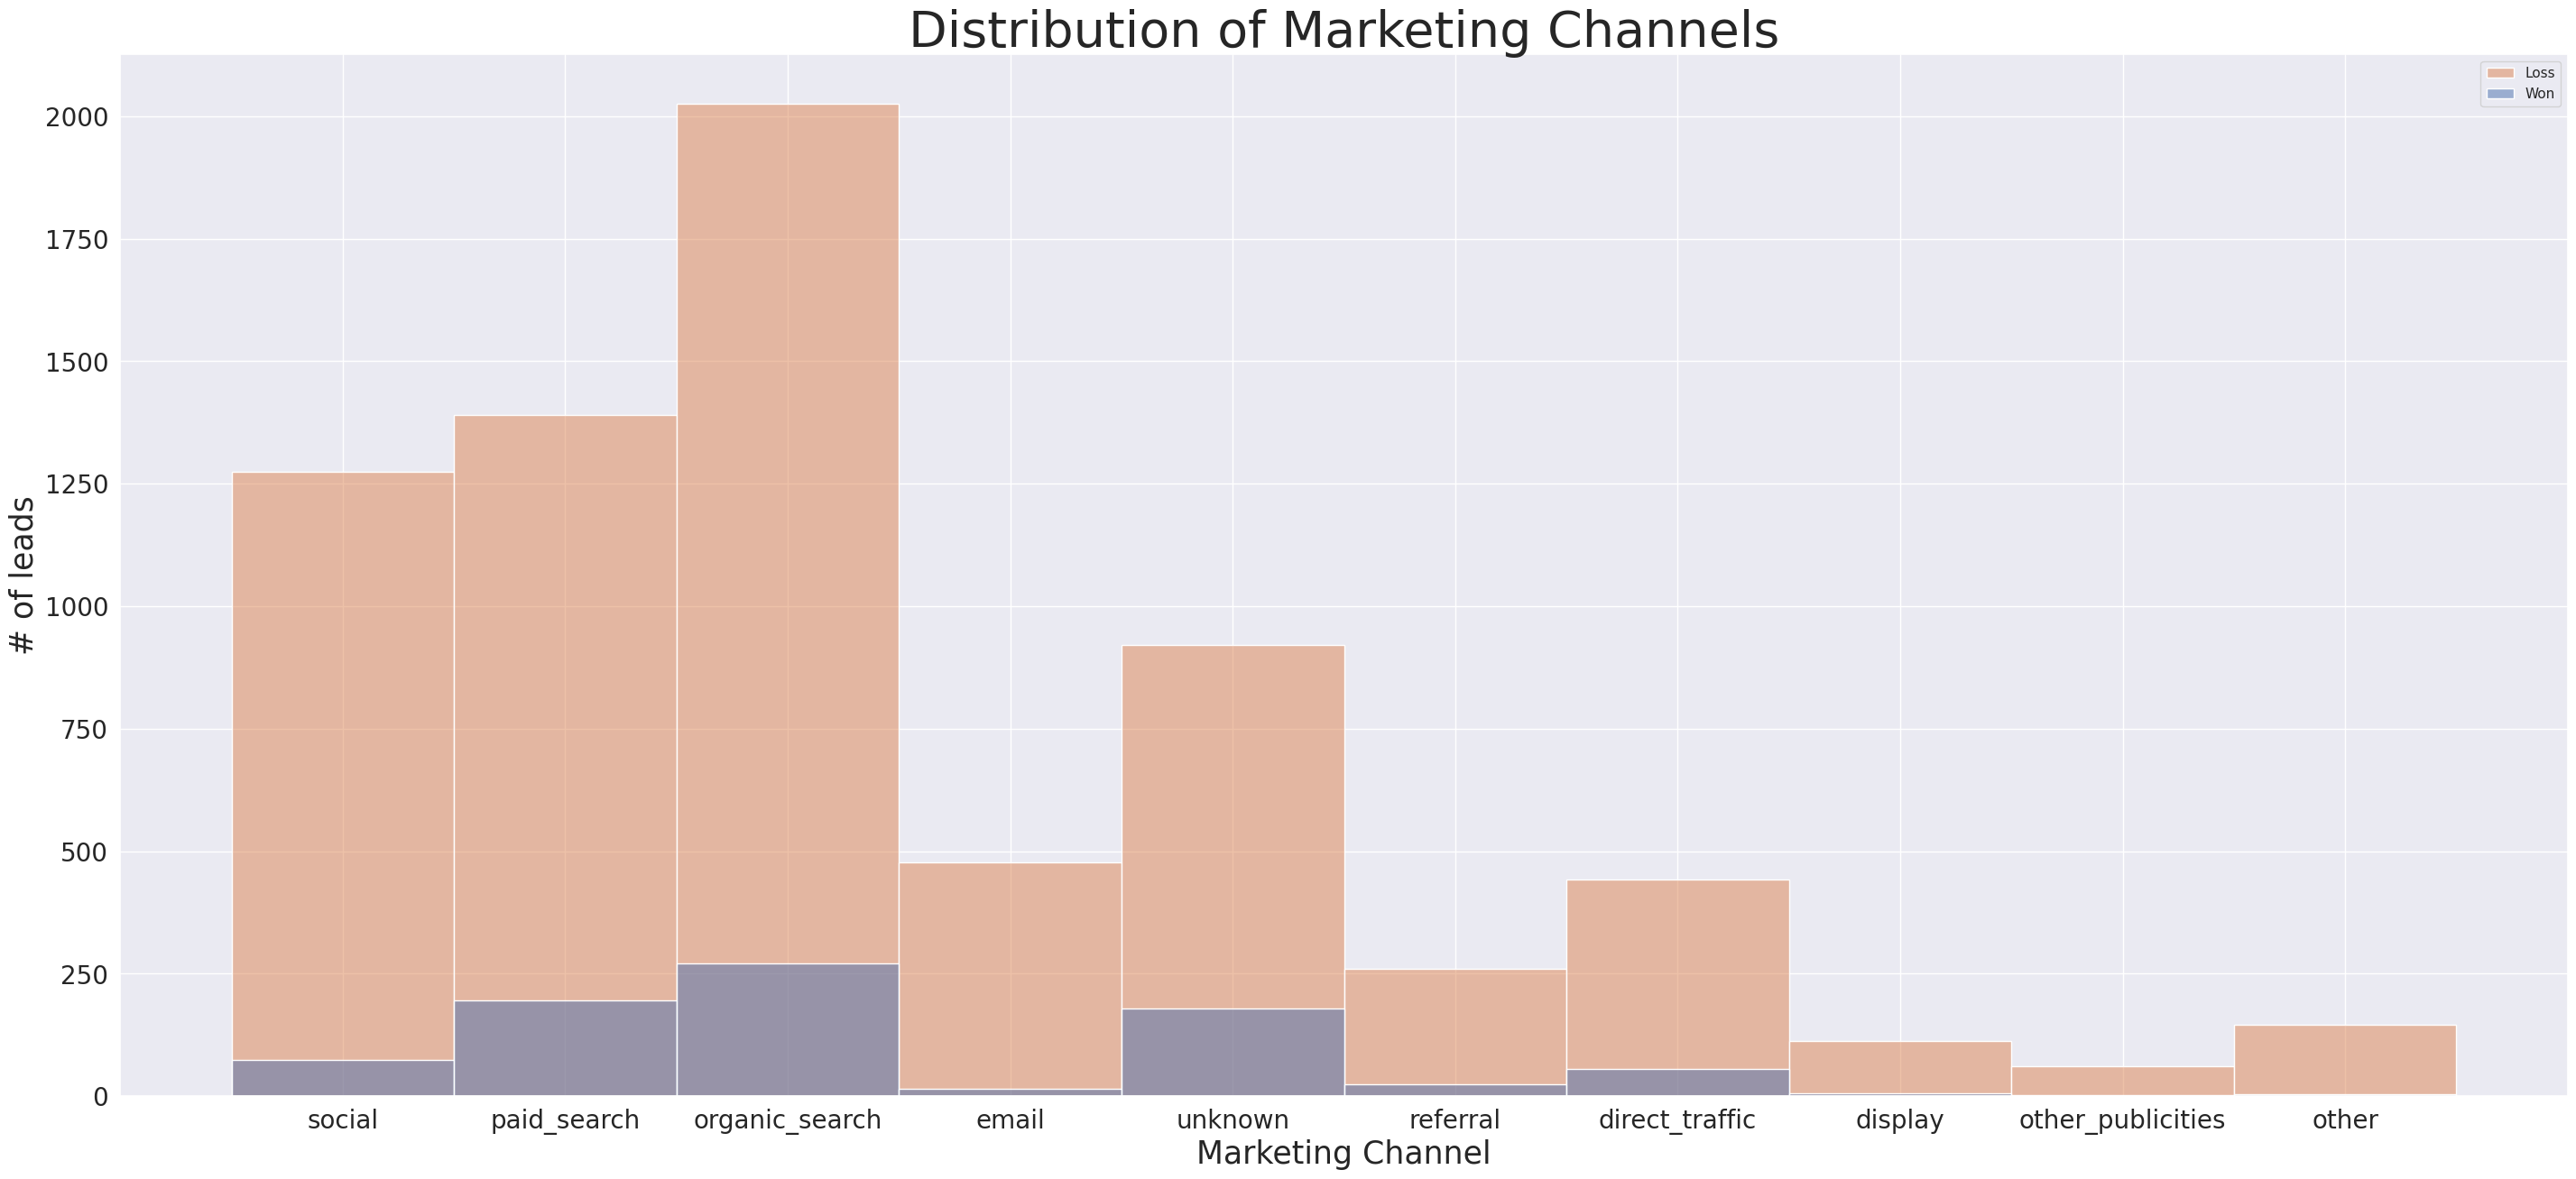

In [50]:
# change color and add title
sns.set(rc={'figure.figsize':(35, 15)})
leads['Deal Failed'] = leads.won_date.isna()
plt.xticks(fontsize = 20), plt.xlabel("Type", fontsize = 25)
plt.xlabel("Marketing Channel")
plt.yticks(fontsize = 20), plt.ylabel("# of leads", fontsize = 25)
plt.title("Distribution of Marketing Channels", fontsize = 40)
sns.histplot(data=leads, x="origin", color = 'green', hue = 'Deal Failed')
plt.legend(['Loss', 'Won'])
plt.show()

## this heatmap shows how different marketing channels evolved over time

Text(0.5, 1.0, 'Heatmap of Marketing Channels Volume')

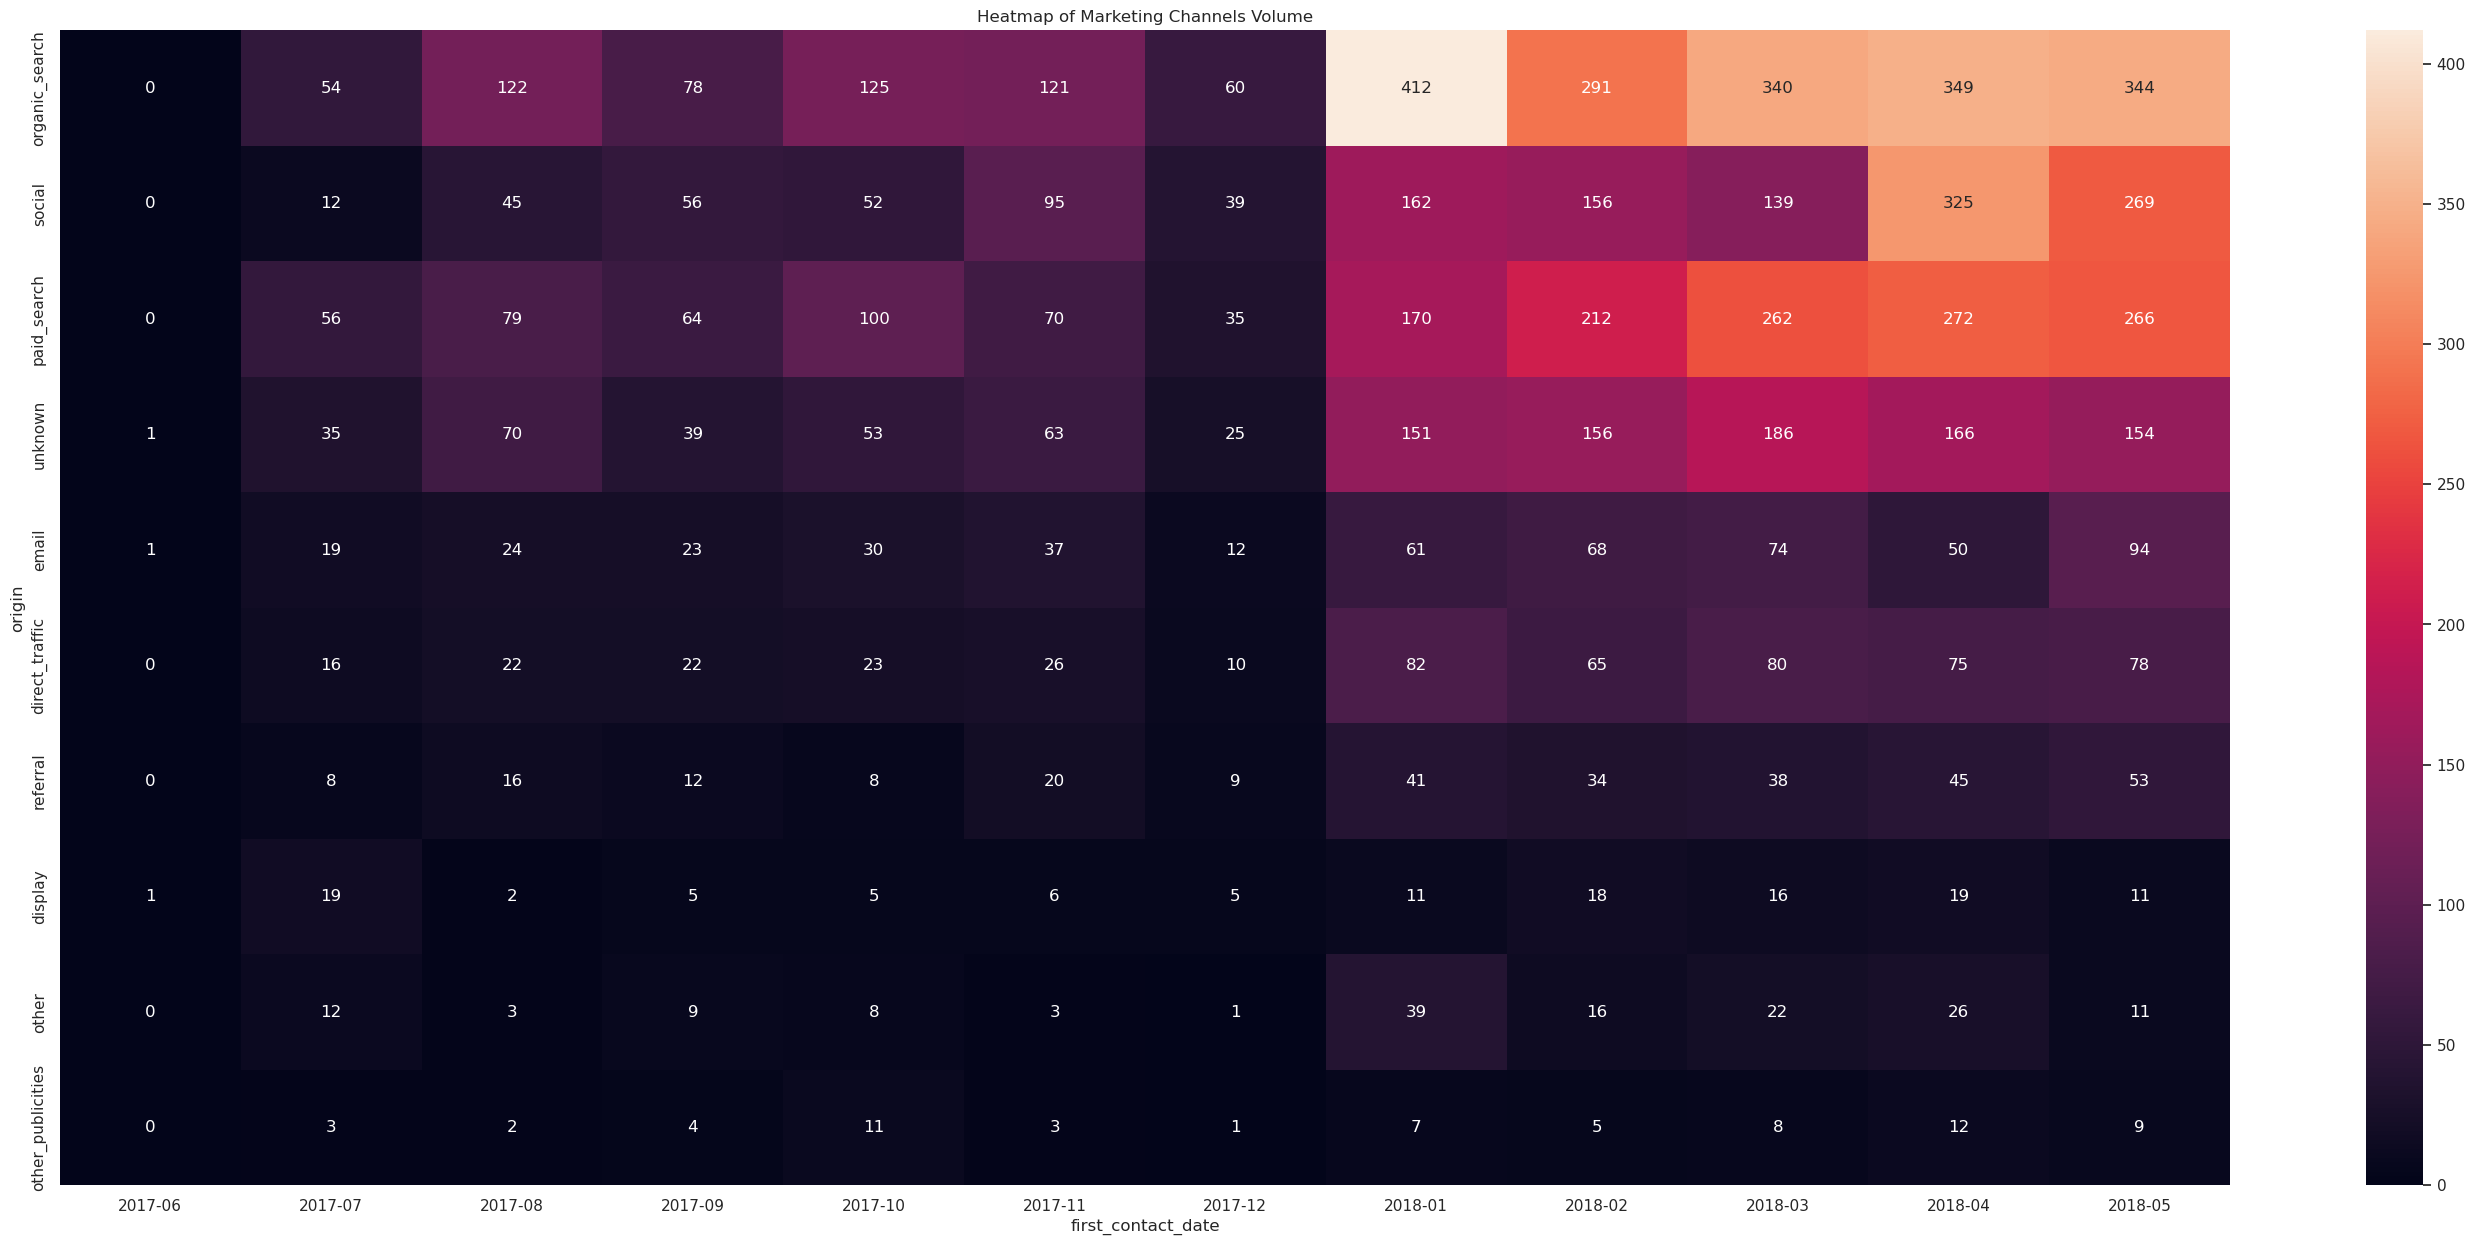

In [51]:
pivot = pd.pivot_table(mql, index='origin',columns='first_contact_date', values='mql_id', aggfunc='count', fill_value = 0)
pivot = pivot.sort_values(by = '2018-05', ascending = False)
sns.heatmap(pivot, annot = True, fmt = 'g')
plt.title("Heatmap of Marketing Channels Volume")

# conversion rates by channel 1d Heatmap

<AxesSubplot:ylabel='origin'>

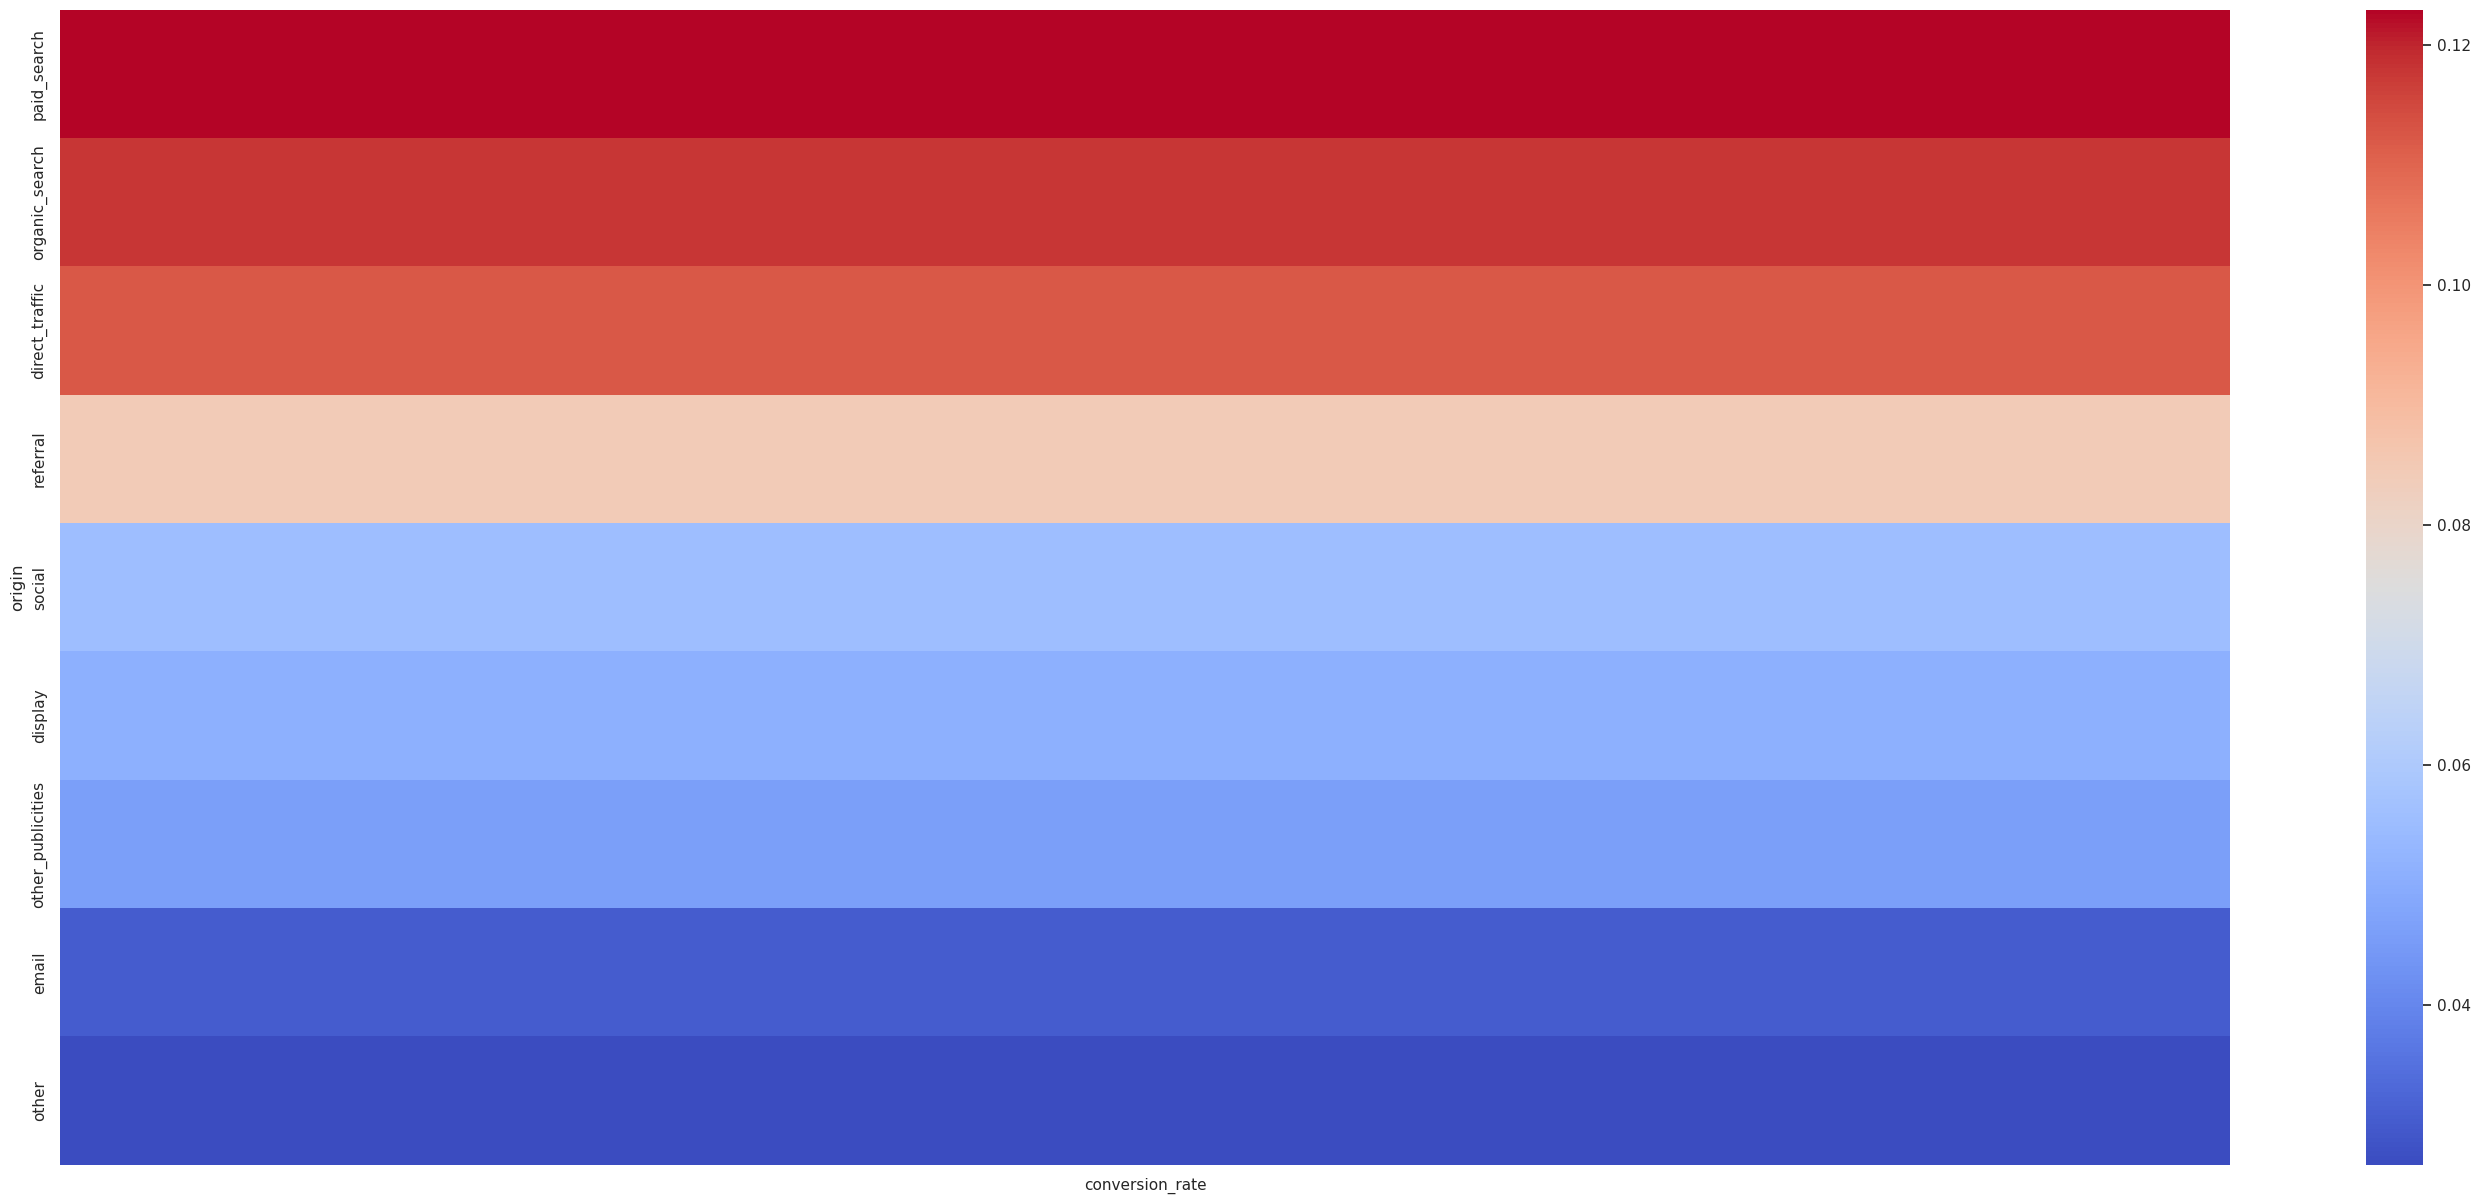

In [52]:
store = store.set_index(store.origin)
store.drop('origin', axis = 1, inplace=True)
store.drop('unknown', axis = 0, inplace = True)
sns.heatmap(store.sort_values(by = 'conversion_rate', ascending = False), cmap = 'coolwarm') 

## and here is a 2d heatmap demonstrating how these marketing channels' conversion rates evolved over time. As you can see each marketing channel has a much higher conversion rate in 2018 than in 2017 despite overall lead volume going up.

Text(0.5, 1.0, 'Conversion Rates over Time')

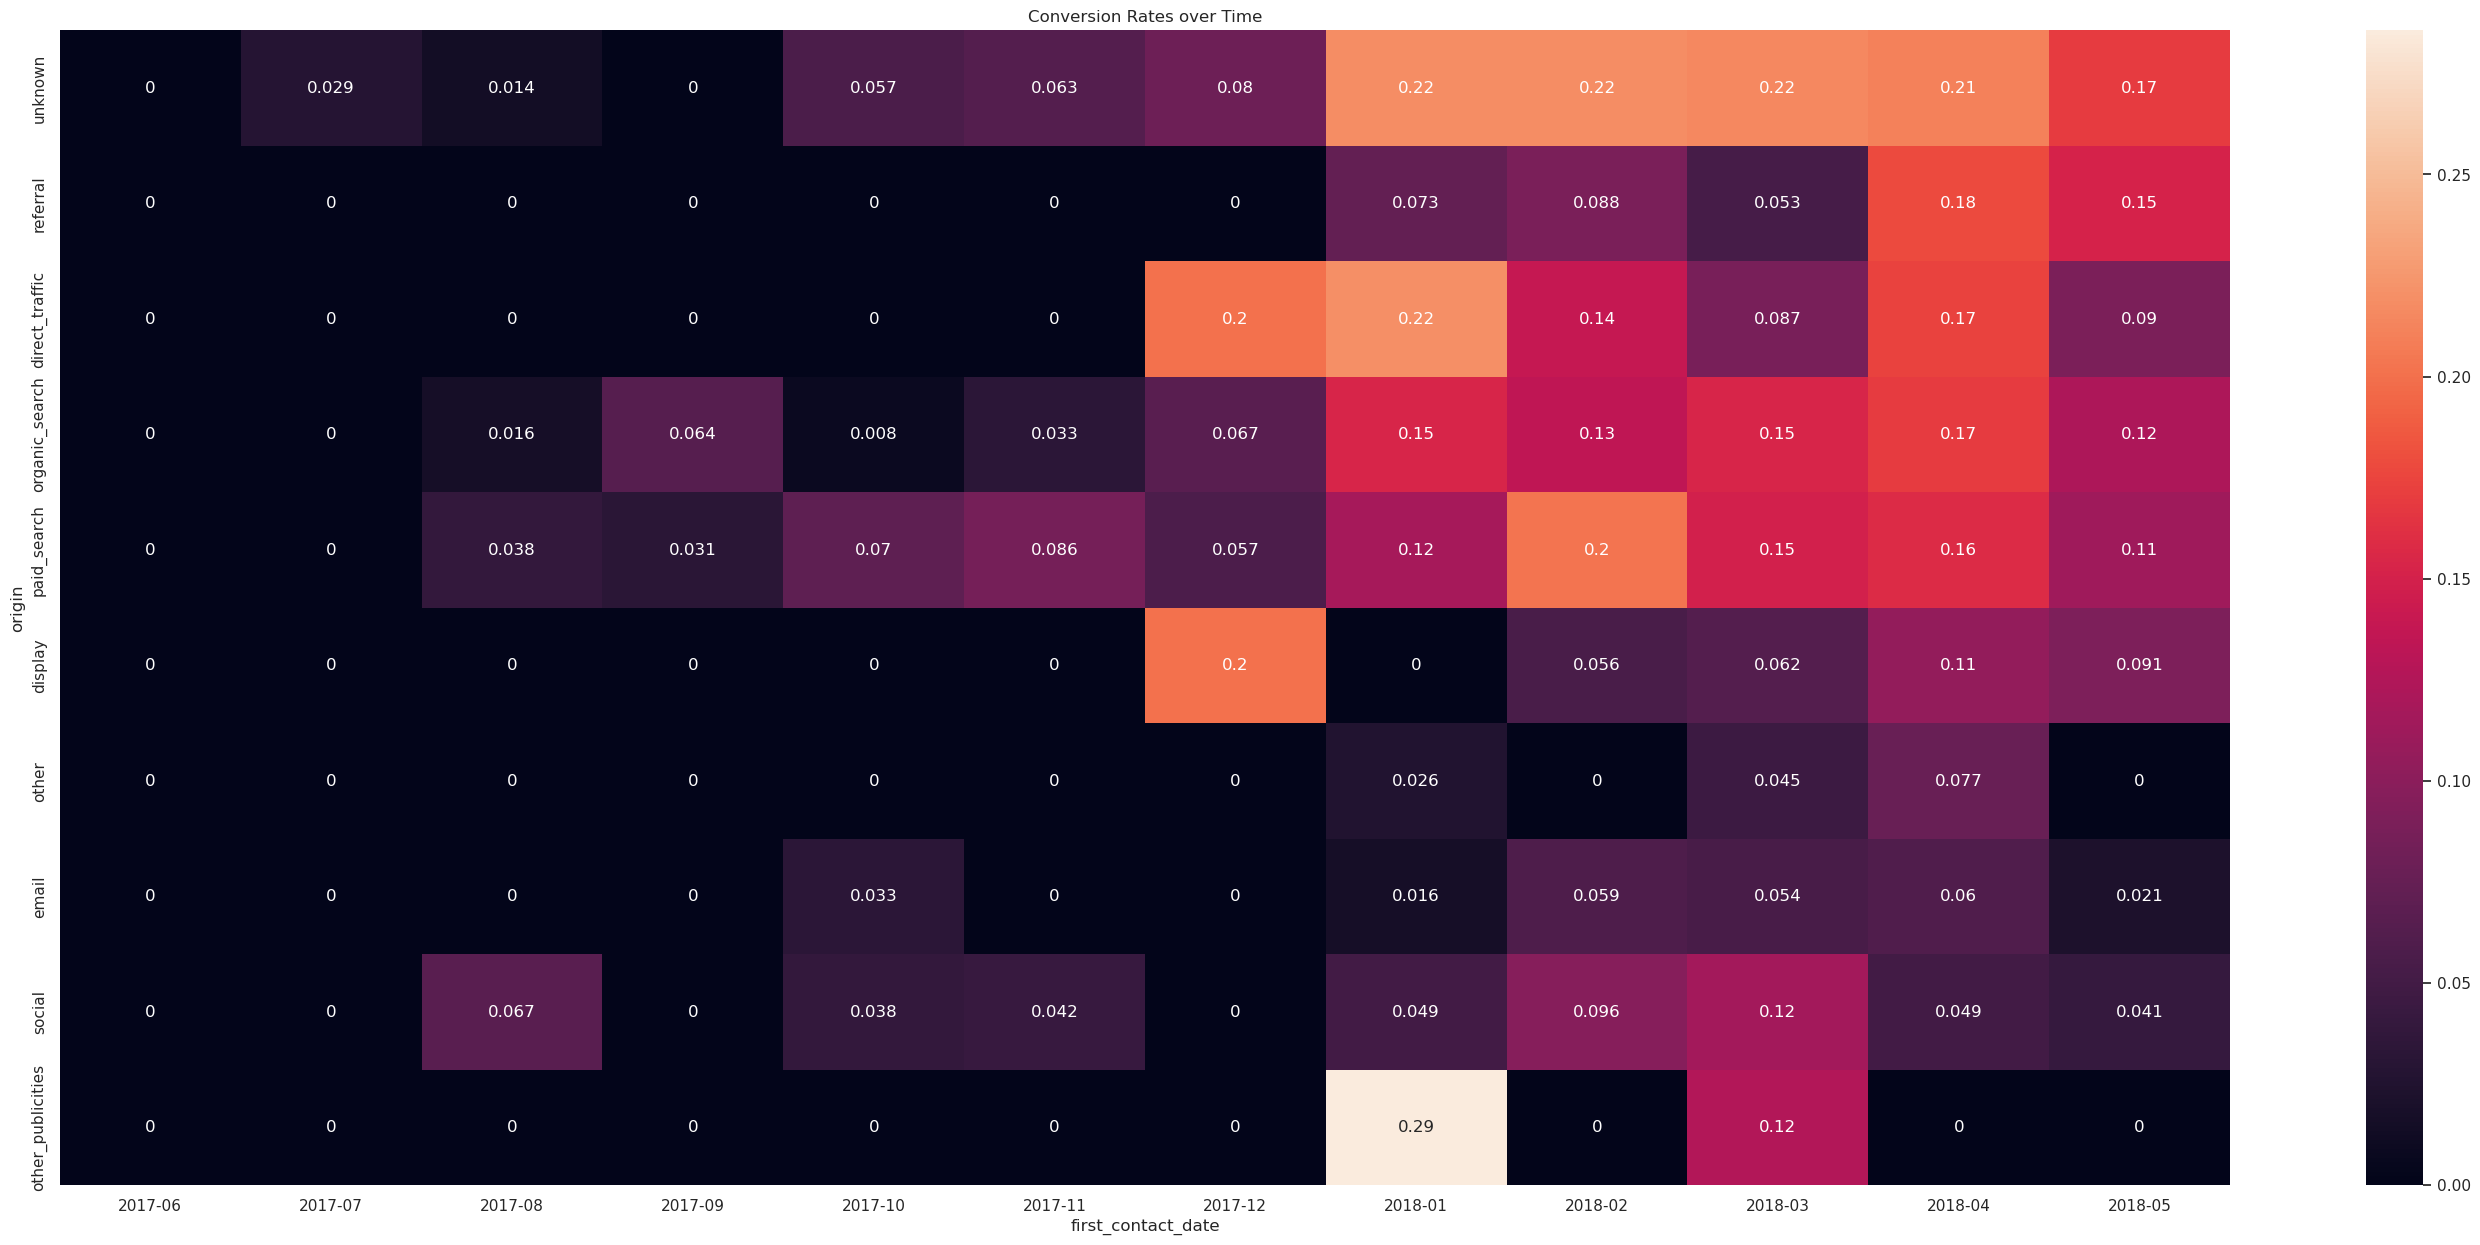

In [53]:
store = pd.DataFrame(leads.groupby(['origin', 'first_contact_date']).apply(lambda x: len(x[x.won_date.isna() == False]) / len(x))).reset_index()
pivot_2 = pd.pivot_table(store, index='origin',columns='first_contact_date', values=0, fill_value = 0)
pivot_2 = pivot_2.sort_values(by = '2018-04', ascending = False)
sns.heatmap(pivot_2, annot = True, fmt = '.2g')
plt.title("Conversion Rates over Time")

# Thank you for reading my notebook :)  All feedback and advice is appreciated!